## Forecasting de Atendimentos Hospitalares

### Modelo Preditivo para a Quantidade de Atendimentos por Dia

<img src= "../imagens/dash-health.jpg" width="45%" align="left">

### 1. Contexto de Negócio:
Previsão da quantidade de Atendimentos Hospitalares por Especialidade Médica, Tipo de Atendimentos (Consultas, Exames, tratamentos, Internações, etc.) e Convênio possibilita o planejamento de agendas médicas, remanejamento de recursos e oferta de serviços com maior eficiência e melhor atendimento. 

Do ponto de vista financeiro, a previsão de atendimentos poderá servir de base para outras ações como projetar receitas futuras, ajudar na gestão de fluxo de caixa e na elaboração de orçamentos, na redução de custos operacionais, Análise de Rentabilidade, Gestão de Estoque, Gestão de Leitos e até estratégias de marketing.

Portanto, é uma ação estratégica para maior qualidade de tratamento ao paciente e para otimizar resultados na instituição.

Os gráficos seguintes mostram alguns números gerais sobre os totais por ano e agrupamentos demográficos do nosso cenário de Atendimentos.

<img src= "../imagens/dash_atend.PNG" width="80%" align="left">

### 2. Abordagem inicial utilizada:

Entre métodos possíveis para criar um Modelo Preditivo que resolva este tipo de problema, os mais frequentes são:

- Modelos clássicos de séries temporais
- Modelos supervisionados Regressivos
- Modelos baseados em aprendizagem profunda.

A escolha da complexidade técnica inicial é uma questão de capacidade do projeto e experiência da equipe. Mas, é natural selecionar técnicas menos complexas primeiro. Assim, prever a quantidade de algo em determinada janela de tempo é um problema clássico  ser modelado com uma **Série Temporal univariante**.

#### 2.1 Séries Temporais

Série temporal é um conjunto de **valores em determinados momento, coletado em intervalos de tempo constantes**. Por meio dela, podemos encontrar padrões de comportamento que permitam prever valores futuros.

Conceitos importante para modelar Séries Temporais e realizar previsão de valores:

**Tendência**: indica a propensão no comportamento dos valores ao longo do tempo, ou seja, a direção geral do movimento - por exemplo, se tem tendência positiva, o valor da variável resposta aumenta com o passar do tempo.

A maioria das séries temporais apresentam alguma **sazonalidade** (comportamentos semelhantes ou repetitivos em períodos equivalentes).

**Autocovariância** é a covariância entre a série temporal e seus próprios dados com um fator de "atraso" constante (n unidades de tempo anteriores). A **covariância** quantifica o grau de relacionamento linear entre duas variáveis, ou seja, como elas se 'movem' em conjunto aumentando ou diminuindo quando a outra varia. Se não houver relação linear entre as variáveis, a covariância será próxima de zero.

**Ruído** são os erros nas previsões, ou seja, a variabilidade numa série temporal que não pode ser explicada pela sazonalidade nem por uma tendência.

**Estacionariedade** de uma série temporal: 
é preciso que medidas estatísticas nas séries temporais, como média e variância, permaneçam constantes ao longo do tempo, além de uma autocovariância que não dependa do tempo, para que ela seja **estacionária**.

In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

from scipy.stats import boxcox
from scipy.stats import shapiro
from scipy import stats

from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from prophet.plot import plot_plotly

from datetime import datetime, timedelta
from pandas.plotting import autocorrelation_plot

import xgboost
import statsmodels.api as sm
import plotly.offline as py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import zipfile
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Para restaurar as configurações de avisos:
#warnings.filterwarnings('default')

# habilitar a visualização interativa de gráficos diretamente no notebook Jupyter.
py.init_notebook_mode()
# magic command para renderizar os gráficos diretamente no notebook.
%matplotlib 
# visualização dos gráficos do matplotlib no tema fivethirtyeight, inspirado no site de análises estatísticas FiveThirtyEight.
plt.style.use('fivethirtyeight')

Using matplotlib backend: module://matplotlib_inline.backend_inline


### 3. Manipulação Inicial de Arquivos

In [3]:
dataset_path = '../datasets/'
file = 'atendimento_serie.csv'
file_zip = 'atendimento_serie.zip'
sys.path.append('libs')
import operacoes as op

if(not os.path.isfile(dataset_path + file)):
    print("Unzipping File")
    dataset_zip = zipfile.ZipFile(dataset_path + file_zip)
    dataset_zip.extractall(dataset_path)
    dataset_zip.close()

Obs.: Documentações sobre a conversão e o formato de data:

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

#### Configurando o ambiente para acesso ao arquivo (dataset) e bibliotecas

O dataset é composto pela quantidade diária de atendimentos, em um período de 2 anos

In [7]:
DATETIME_FORMAT = '%d-%m-%Y %H:%M:%S'
DATE_FORMAT = '%d-%m-%Y'
#DATE_FORMATY = '%Y-%m-%d'

%matplotlib inline
plt.style.use('fivethirtyeight')
CONSULTA = 'A'
EXAME = 'E'
URGENCIA = 'U'
INTERNACAO = 'I'

In [5]:
def data_hora(dia, mes, ano):
    return datetime(ano,mes,dia)

def data(dia, mes, ano):
    return datetime(ano,mes,dia)

### 3.1 Carregamento do Conjunto de Dados

In [6]:
ds_atendimentos = op.le_planilha( dataset_path + file, separador=";")

In [7]:
ds_atendimentos.head()

Unnamed: 0  Local_Atendimento  Convenio Tipo_conta                 Data  \
0           0                  9         7          C  12-10-2021 00:00:00   
1           1                 13        41          C  14-03-2019 00:00:00   
2           2                  1         7          C  18-11-2019 00:00:00   
3           3                  3         7          C  18-11-2019 00:00:00   
4           4                  3         7          C  21-11-2019 00:00:00   

  Tipo_atendimento  Medico  
0                U   31148  
1                E       1  
2                A     959  
3                E       1  
4                E    7491

#### 3.1.1 Descrição dos Dados:
- Local_Atendimento: setor em que o paciente inicia o atendimento
- Convenio: Código da Operadora de saúde do Paciente
- tipo_conta: Se o paciente foi atendido pelo Convênio ou Particular
- data: dia e hora que o paciente iniciou o atendimento
- Tipo_atendimento: (I)nternação, Consult(A), (E)xame, (U)rgência
- Medico: código do médico que atendeu o paciente


#### 3.1.2 Análise dos dados

1 - Existem dados faltando?

In [8]:
ds_atendimentos.isnull().sum()

Unnamed: 0           0
Local_Atendimento    0
Convenio             0
Tipo_conta           0
Data                 0
Tipo_atendimento     0
Medico               0
dtype: int64

##### Total de Amostras e Percentual por Tipo de Atendimento

In [9]:
total = ds_atendimentos.count()[0]
percentual = (ds_atendimentos.groupby('Tipo_atendimento').size()/total)*100
print('Total:', total)
print('Percentual:',percentual)

Total: 1864791
Percentual: Tipo_atendimento
A    32.143763
E    28.386398
I     6.687076
U    32.782762
dtype: float64


Nenhuma coluna apresenta valores nulos.

2 - Como estão os tipos de dados da carga?

In [10]:
ds_atendimentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1864791 entries, 0 to 1864790
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Unnamed: 0         int64 
 1   Local_Atendimento  int64 
 2   Convenio           int64 
 3   Tipo_conta         object
 4   Data               object
 5   Tipo_atendimento   object
 6   Medico             int64 
dtypes: int64(4), object(3)
memory usage: 99.6+ MB


Convertendo a coluna de Data-hora (utilizando a nossa biblioteca Operacoes em 'libs/operacoes.py' )

In [11]:
op.converte_para_datetime(ds_atendimentos, ['Data'], format=DATETIME_FORMAT)

In [12]:
ds_atendimentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1864791 entries, 0 to 1864790
Data columns (total 7 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   Local_Atendimento  int64         
 2   Convenio           int64         
 3   Tipo_conta         object        
 4   Data               datetime64[ns]
 5   Tipo_atendimento   object        
 6   Medico             int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 99.6+ MB


In [13]:
print("Amplitude de datas. De: ", ds_atendimentos['Data'].min(), ' a ', ds_atendimentos['Data'].max())

Amplitude de datas. De:  2019-01-01 00:00:00  a  2023-11-02 00:00:00


Criando o Dataset de Agrupamento (contagem) de Atendimentos/dia

Agrupamento > Tipo_Atendimento, Data

In [9]:
def agrupa_totais_por(df_atendimento, colunas_agrupadas):
    # Considerar apenas o dia do atendimento (sem as horas)
    df_atendimento['Dia_Atendimento'] = ds_atendimentos['Data'].dt.date
    ds_total = df_atendimento.groupby(colunas_agrupadas).size().reset_index(name='Total_atendimentos')
    return ds_total

def filtra_dados_por_tipo(dataset, tipo):
    return dataset[dataset['Tipo_atendimento']==tipo]

In [15]:
ds_tot_atendimento = agrupa_totais_por(ds_atendimentos, ['Tipo_atendimento', 'Dia_Atendimento'])

In [16]:
ds_tot_atendimento.tail()

Tipo_atendimento Dia_Atendimento  Total_atendimentos
6987                U      2023-10-28                 336
6988                U      2023-10-29                 341
6989                U      2023-10-30                 531
6990                U      2023-10-31                 407
6991                U      2023-11-01                 323

In [17]:
ds_tot_atendimento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992 entries, 0 to 6991
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Tipo_atendimento    6992 non-null   object
 1   Dia_Atendimento     6992 non-null   object
 2   Total_atendimentos  6992 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 164.0+ KB


In [18]:
op.converte_para_datetime(ds_tot_atendimento, ['Dia_Atendimento'], format=DATE_FORMAT)
print("Amplitude de datas. De: ", ds_tot_atendimento['Dia_Atendimento'].min(), ' A ', ds_tot_atendimento['Dia_Atendimento'].max())

Amplitude de datas. De:  2019-01-01 00:00:00  A  2023-11-02 00:00:00


Vamos criar algumas rotinas para plotar os gráficos, incluindo aqueles com os valores "real" e "predição" 

In [4]:
def plota_serie_temporal(X, y, tituloY):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(X, y, alpha=0.7, linewidth=1)
    ax.set_xlabel('Data', fontsize=13)
    ax.set_ylabel('Qt.Atendimentos ' + tituloY, fontsize=13)
    plt.xticks(rotation=90, ha='right')
    ax.grid(visible=True, axis='y')
    plt.show()

def plota_zoom_serie_temporal(X, y, dataIni, dataFim):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(X, y, alpha=0.7, linewidth=1)
    ax.set_xlabel('Data', fontsize=13)
    ax.set_ylabel('Qt.Atendimentos', fontsize=13)
    ax.set_xlim(left=dataIni, right=dataFim)
    ax.grid(visible=True, axis='y')
    plt.xticks(rotation=90, ha='right')
    plt.show()

def plots_simultaneos(serie_real, serie_prevista):
    figs, axs = plt.subplots(figsize=(10, 6))
    axs.plot(serie_real.index, serie_real, label='Total Atendimentos - Real')
    axs.plot(serie_prevista.index, serie_prevista, label='Total Atendimentos - Previsto')
    axs.set_xlabel('Steps')
    axs.set_ylabel('Total Atendimentos')    
    axs.legend()
    plt.xticks(rotation=90, ha='right')
    plt.show()

In [20]:
filtra_dados_por_tipo(ds_tot_atendimento, EXAME).head()

Tipo_atendimento Dia_Atendimento  Total_atendimentos
1695                E      2019-01-01                   1
1696                E      2019-01-02                 207
1697                E      2019-01-03                 294
1698                E      2019-01-04                 353
1699                E      2019-01-05                 185

In [21]:
'''
ds_tot_atend_dia.index = ds_tot_atendimento["Dia_Atendimento"]
ds_tot_atend_dia = ds_tot_atend_dia.sort_index()
'''
ds_tot_atend_dia = ds_tot_atendimento.sort_values(by="Dia_Atendimento")

### 4. Análise Exploratória de Dados - EDA

Dada a natureza distinta de cada tipo de atendimento, a previsão inicial será feita considerando apenas as consultas médicas

In [22]:
ds_tot_consulta = filtra_dados_por_tipo(ds_tot_atendimento, CONSULTA)
ds_tot_consulta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1695 entries, 0 to 1694
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Tipo_atendimento    1695 non-null   object        
 1   Dia_Atendimento     1695 non-null   datetime64[ns]
 2   Total_atendimentos  1695 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 53.0+ KB


In [23]:
ds_tot_consulta = ds_tot_consulta[['Dia_Atendimento', 'Total_atendimentos']]

In [24]:
op.converte_para_datetime(ds_tot_consulta,['Dia_Atendimento'])

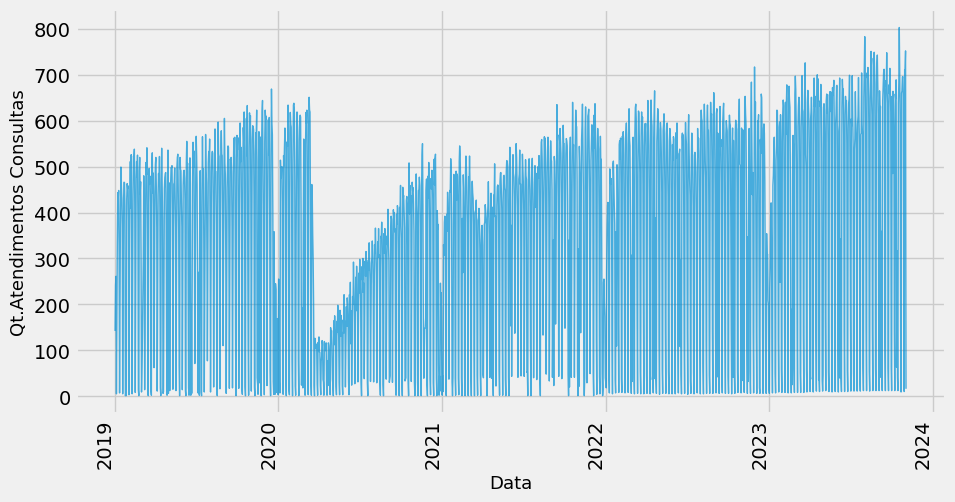

In [25]:
plota_serie_temporal(ds_tot_consulta['Dia_Atendimento'],ds_tot_consulta['Total_atendimentos'], 'Consultas')

Observamos claramente a **baixa repentina** de consultas no **início de 2020** devido à pandemia de COVID-19, voltando gradualmente, mas só retornando aos mesmos níveis a partir do último trimestre de 2021 em diante. As movimentações concentradas em ___Internações___ por COVID e a possibilidade de contágio reduziram drasticamente as ___Consultas___ até o primeiro semestre de 2021.

#### Zoom em um Período
O plot da Série do período completo oferece uma visão macro, mas difícil de interpretar em detalhes. Olhar mais de perto um corte aleatório de um período curto pode fornecer um entendimento melhor. 

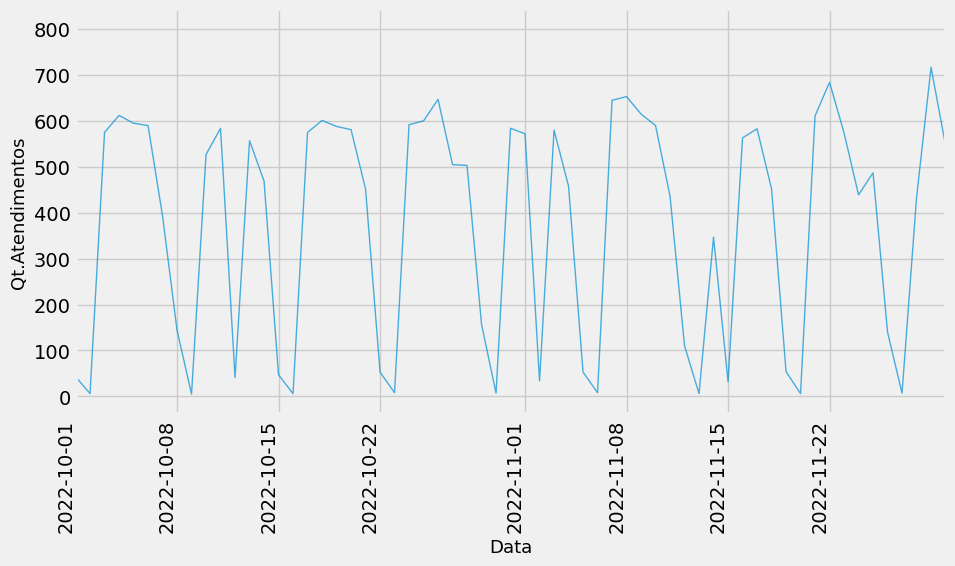

In [26]:
dataInicial = data(1, 10, 2022)
dataFinal = data(30, 11, 2022)
plota_zoom_serie_temporal(ds_tot_consulta['Dia_Atendimento'],ds_tot_consulta['Total_atendimentos'], dataInicial, dataFinal)

A quais dias correspondem os picos e quais dias correspondem as baixas? 

O dia 08/11/2022, por exemplo, é uma terça. O pico acontece no dia 09, uma quarta. Entre os dias 08 e 15 aparace um comportamento diferente das demais semanas: um "dente" menor do que os outros. Neste caso, quando a quantidade de Atendimentos deveria estar aumentando a partir do Domingo até quarta, acontece uma súbita diminução no dia 15/11 (Feriado de Proclamação da República). 

#### 4.1 Estatísticas dos Dados

In [27]:
#Análise Estatística
ds_tot_consulta['Total_atendimentos'].describe()

count    1695.000000
mean      353.636578
std       233.214795
min         1.000000
25%        80.000000
50%       430.000000
75%       548.000000
max       803.000000
Name: Total_atendimentos, dtype: float64

##### Analisando Maiores e Menores quantidades de Atendimentos

In [28]:
#Além do maior e menor valor para a quantidade de consultas por dia, 
#vamos olhar o padrão de "n" maiores e menores
ds_4_maiores = ds_tot_consulta['Total_atendimentos'].nlargest(n=4)
ds_4_menores = ds_tot_consulta['Total_atendimentos'].nsmallest(n=4)
print("4 Maiores")
print(ds_4_maiores)
print("4 Menores")
print(ds_4_menores)

4 Maiores
1679    803
1602    783
1693    752
1616    751
Name: Total_atendimentos, dtype: int64
4 Menores
20    1
22    1
47    1
65    1
Name: Total_atendimentos, dtype: int64


Segundo as estatísticas, os menores valores é 1 consulta/dia e os maiores são 803, 783, 752 e 751 consultas/dia.

Quais **dias da semana** possuem as menores e as maiores quantidades de Atendimento do tipo "Consulta"?

Quais os **dias da semana** com apenas **1 Consulta**?

Vamos imprimir alguns dias:

In [29]:
dia_1_atd = ds_tot_consulta.loc[ds_4_menores.index]['Dia_Atendimento']
for dia in dia_1_atd[dia_1_atd.index]:
    print(dia.strftime('%A'), dia)

Friday 2019-01-25 00:00:00
Sunday 2019-01-27 00:00:00
Sunday 2019-02-24 00:00:00
Sunday 2019-03-17 00:00:00


O dia de menos frequência é no Domingo e apenas uma sexta feira (25/01) que aparece é feriado municipal na cidade

Que dia da semana houve as maiores quantidades de consultas?

In [30]:
dia_mais_atd = ds_tot_consulta.loc[ds_4_maiores.index]['Dia_Atendimento']
for dia in dia_mais_atd[dia_mais_atd.index]:
    print(dia.strftime('%A'), dia)

Wednesday 2023-10-18 00:00:00
Wednesday 2023-08-02 00:00:00
Wednesday 2023-11-01 00:00:00
Wednesday 2023-08-16 00:00:00


A quarta feira parece ser frequentemente o dia com mais consultas.


#### Boxplot
O Boxplot é um gráfico que mostra a distribuição dos valores em um atributo através de uma "caixa" que exibe o limite inferior, quartil 1 (Q1), mediana (igual ao Q2), quartil 3 (Q3), limite superior e eventuais outliers. Por não levar em consideração  referências à média e nem sofrer influencia de outliers, são bons para análise de distribuições não-normais / assimétricas.

A **Mediana** (linha central da caixa) é o elemento central dos dados ordenados de forma crescente (50% dos valores serão menores ou iguais a ela e os outros 50% serão maiores ou iguais). 

Os **Quartis** (percentis que dividem o conjunto em 4 partes) ordenam os valores e fatiam em Q1 (25% - base da caixa), Q2 (50% - linha da Mediana) e Q3 (75% - topo da caixa). Naturalmente, Q4 equivale à fatia final do que resta aos 100%. A altura da "caixa" será à diferença Q3 - Q1 (ou amplitude interquartil).

As linhas de **Base** e **Topo** são o maior e menor valor do atributo, desconsiderando os outliers.

Os **Outliers** (pontos acima e abaixo das linhas base) são valores extremos que podem ser calculados estatisticamente em função da amplitude interquartil (AIQ) e dos valores de Q1 e Q3 (1,5 é o valor padrão para o fator de cálculo, mas pode ser alterado):

- Outlier inferior < Q1 - (1,5 X AIQ)
- Outlier superior > Q3 + (1,5 X AIQ)

Os valores menores e maiores serão os outliers. Algumas vezes, os outliers são erros de entrada ou valores efetivamente excepcionais, que são incomuns e se não forem tratados (ou removidos) podem causar anomalias nos modelos. Outras vezes, outliers serão definidos de acordo com o conhecimento de domínio e não somente com os limites estatísticos. Por exemplo, sinais vitais do corpo humano, como batimento cardíaco ou temperatura corporal, possuem uma faixa específica, cuja extrapolação pode significar erro de leitura. 

In [31]:
ds_box_plot = ds_tot_consulta.copy()
ds_box_plot['Mes'] = [ds.strftime('%b') for ds in ds_tot_consulta['Dia_Atendimento']]
ds_box_plot['Ano'] = [ds.year for ds in ds_tot_consulta['Dia_Atendimento']]

**Boxplot segmentado por Ano**

<Axes: xlabel='Ano', ylabel='Total_atendimentos'>

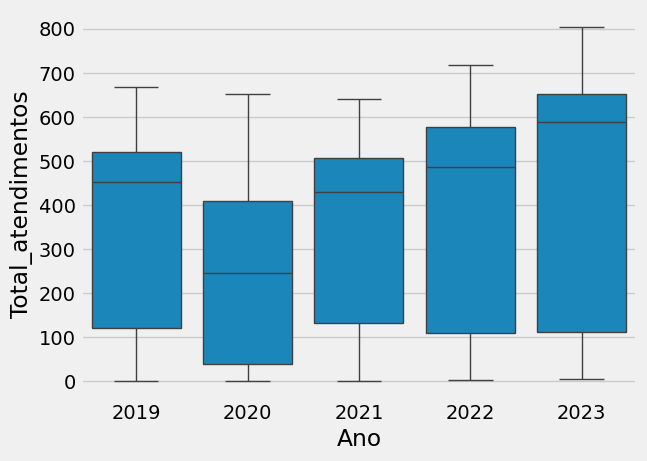

In [32]:
sns.boxplot(x='Ano', y='Total_atendimentos', data=ds_box_plot)

Quanto maior for a amplitude (AIQ), maior a variação nos dados. **Exceto por 2020 (início da pandemia)**, temos grandes amplitudes e a mediana muito próxima ao Q3, portanto os dados são negativamente assimétricos. Devido as características observadas, não existem outliers nos dados.

Os demais anos mantêm uma mediana acima de 400 consultas/dia, subindo gradualmente e chegando próximo a 600 em 2023 - o que é uma tendência interessante para o Hospital. Portanto, mais da metade dos dias dos anos 2019, 2021, 2022 e 2023 possuem **mais de 400 atendimentos/dia**.

Em 2019 e 2021 Q1 tem valores variando entre quase 0 e +/- 50. Mas, após 2022, atinge o patamar de +/- 100. Q2 é a faixa mais variável, mas nos anos de 2022 e 2023 25% dos valores estão entre 100 e 400. 

Dado o comportamento discrepante de 2020 e 2021 vamos analisar os meses excluindo estes anos.

In [33]:
ds_box_plot_22_23 = ds_box_plot[(ds_box_plot['Ano']==2023) | (ds_box_plot['Ano']==2022)]

<Axes: xlabel='Mes', ylabel='Total_atendimentos'>

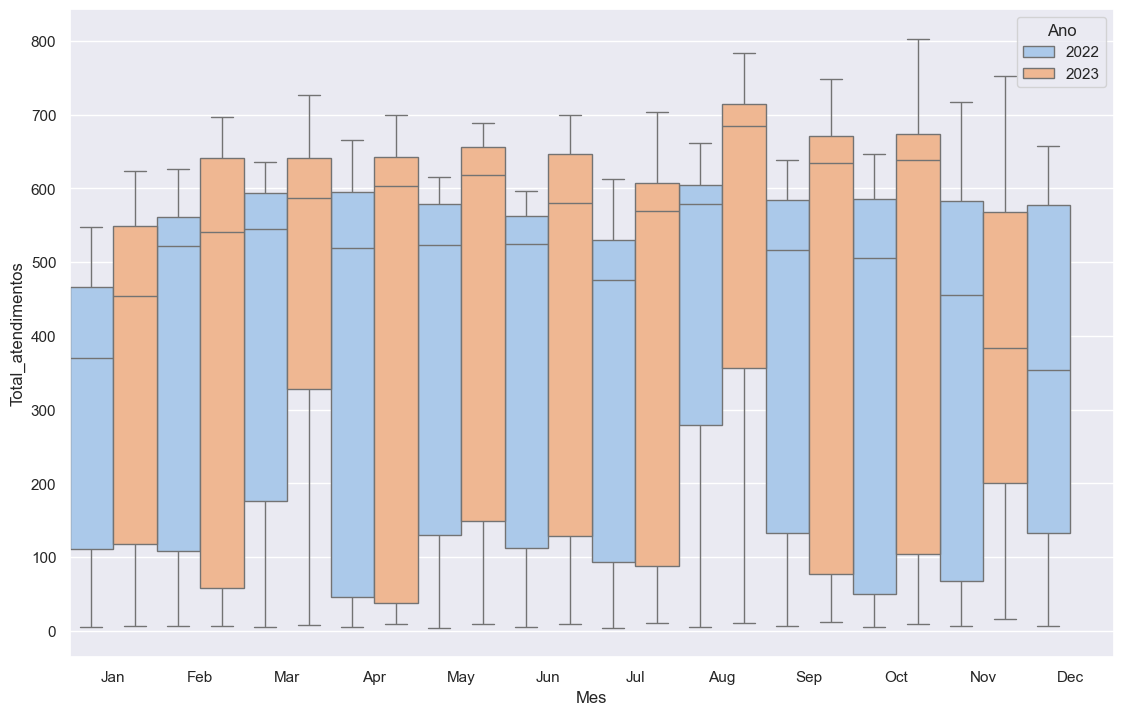

In [34]:
sns.set_theme(rc={'figure.figsize':(12,8)})
sns.boxplot(x='Mes', y='Total_atendimentos', hue='Ano', data=ds_box_plot_22_23, width=1, palette=sns.color_palette("pastel"))

Existe uma assimetria puxando a mediana para cima indicando uma concentração maior dos valores altos na quantidade de atendimentos/dia, que dos baixos. Podemos ver se pegarmos a quantidade de Atendimentos/dia do mês de julho e ordenarmos pela quantidade de atendimentos. Percebemos que existem mais concentração nos valores altos (após a médiana - 569), enquanto nos valores menores que a mediana os valores são mais dispersos.

In [35]:
data1 = data(1, 7, 2023)
data2 = data(31, 7, 2023)

filtro = (ds_tot_consulta['Dia_Atendimento'] >= data1) & (ds_tot_consulta['Dia_Atendimento'] <= data2)
ds_jul_2023 = ds_tot_consulta[filtro]
print('Mediana:',ds_jul_2023['Total_atendimentos'].median())
np.array(ds_jul_2023.sort_values('Total_atendimentos')['Total_atendimentos'])

Mediana: 569.0


array([ 11,  11,  11,  11,  12,  43,  50,  63, 113, 175, 538, 549, 553,
       561, 568, 569, 570, 573, 589, 593, 594, 596, 604, 610, 611, 611,
       651, 663, 694, 698, 704], dtype=int64)

Confirmando o que já foi mostrado no Boxplot Anual, o comportamento geral dos meses é de uma mediana > 400, com exceção de Dezembro e Janeiro (mês de festa e pós-reveillon) que ficam ligeiramente abaixo. Mas, o restante do ano, a mediana se concentra acima dos 400.

Que padrão o ano de 2019 apresenta, já que foi anterior aos anos com o padrão incomum?

<Axes: xlabel='Mes', ylabel='Total_atendimentos'>

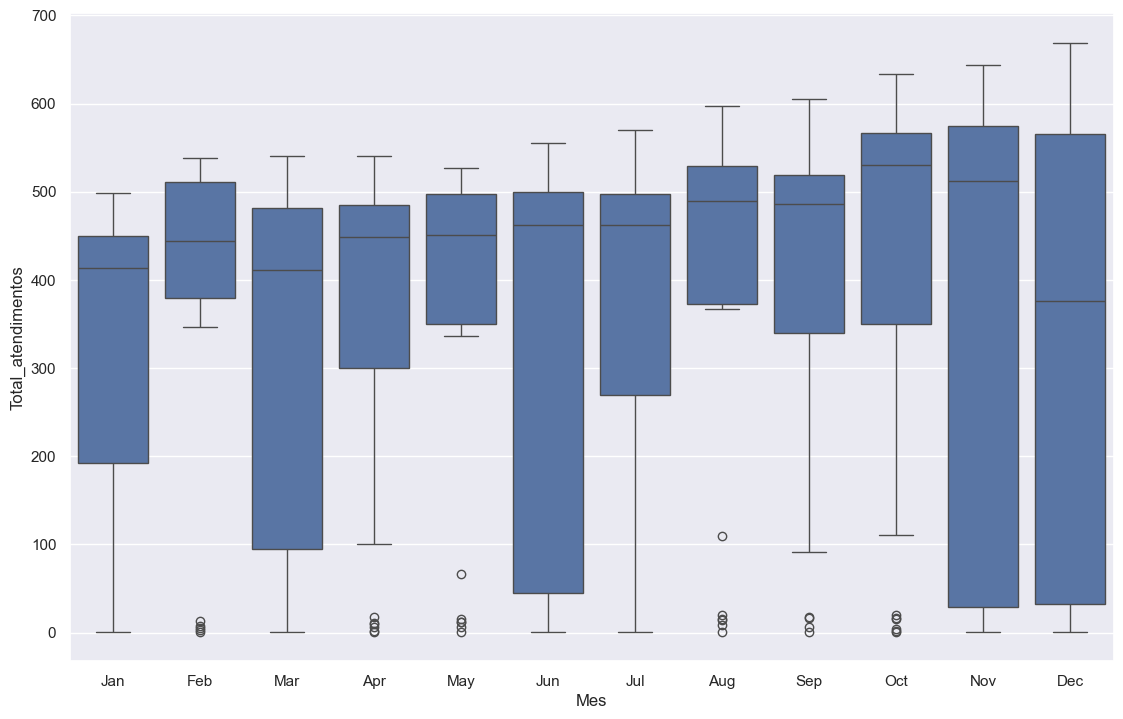

In [36]:
sns.boxplot(x='Mes', y='Total_atendimentos', data=ds_box_plot[ds_box_plot['Ano']==2019])

Um caso curioso ocorre em 2019 nos meses de fevereiro, maio e agosto: a mediana continua alta, com pouquíssimos dias em que a frequencia de pacientes fosse inferior a 350 atendimentos/dia (alguma relação com meses de férias?). Aparentemente, foram meses em que a agenda dos consultórios esteve cheia. Isso faz com que dias com pouco movimento nos consultórios pareçam _outliers_.

Se forem os dias da semana já esperados, não queremos descartá-los, pois é importante que sejam capturados pelo nosso modelo preditivo. Para isso, vamos observar os registros iniciais e finais dos dias inferiores a 50 Atendimentos:

In [37]:
dias_2019_outliers = ds_box_plot[((ds_box_plot['Total_atendimentos']<=50) & (ds_box_plot['Ano']==2019))]

for dia in dias_2019_outliers['Dia_Atendimento'].head(8):
    print(dia.strftime('%A'), dia)

for dia in dias_2019_outliers['Dia_Atendimento'].tail(8):
    print(dia.strftime('%A'), dia)

Saturday 2019-01-05 00:00:00
Saturday 2019-01-12 00:00:00
Saturday 2019-01-19 00:00:00
Friday 2019-01-25 00:00:00
Saturday 2019-01-26 00:00:00
Sunday 2019-01-27 00:00:00
Saturday 2019-02-02 00:00:00
Saturday 2019-02-09 00:00:00
Sunday 2019-12-15 00:00:00
Saturday 2019-12-21 00:00:00
Sunday 2019-12-22 00:00:00
Tuesday 2019-12-24 00:00:00
Wednesday 2019-12-25 00:00:00
Saturday 2019-12-28 00:00:00
Sunday 2019-12-29 00:00:00
Tuesday 2019-12-31 00:00:00


Como o esperado: são Sábado e Domingo. As exceções são uma sexta-feira, 25/01 (já mencionado que é um feriado municipal), Natal e Ano novo (terça e quarta-feira).


#### 4.2 Distribuição dos Valores

A análise de **Distribuição dos Valores** permite **escolhas** mais assertivas dos **algorítmos e testes estatísticos**. A seleção de métodos paramétricos ou não-paramétricos, por exemplo, pode depender de aspectos da amostra e de características da distribuição dos valores. Normalmente, avaliamos a Distribuição Normal (Gaussiana) em variáveis contínuas. Mas, amostras grandes de dados discretos podem ser tratadas como aproximadamente contínuos e a Distribuição Normal pode ser uma escolha razoável.

#### **Exemplo** de uma distribuição Normal (Artificial)

In [38]:
def plot_histograma(coluna, qt_bins=10):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(x=coluna, color='blue', bins=qt_bins, density=True)
    plt.axvline(coluna.mean(), color='k', linestyle='dashed', linewidth=2)
    ax.grid(True, axis='y')
    plt.show()

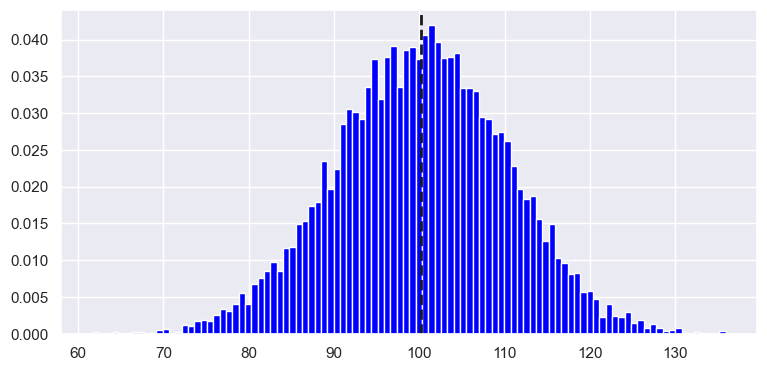

In [39]:
pos = 100
scale = 10
size = 10000
normal = np.random.normal(pos, scale, size)
plot_histograma(normal, 100)

A Distribuição Normal (Gaussiana) apresenta a forma simétrica de sino. 

##### 4.2.1 Histograma da quantidade de Atendimentos 

Plotando o Histograma dos dados da Série Temporal

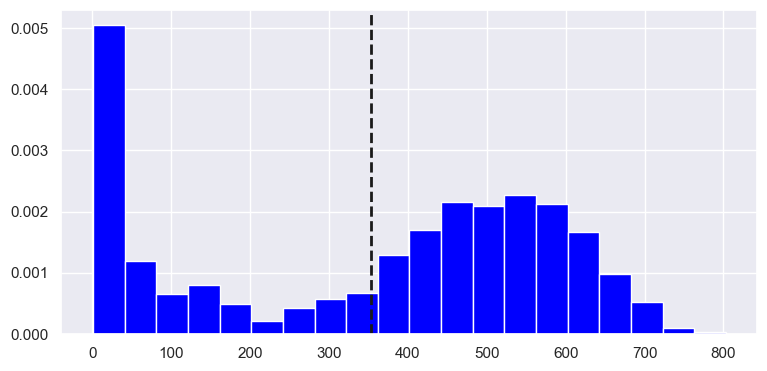

In [40]:
plot_histograma(ds_tot_consulta['Total_atendimentos'],20)

#### Transformações nos Dados

Observamos que o histograma mostra uma distribuição com quantidades maiores nas extremidades, portanto, sugerindo a existência de dois padrões ou comportamentos diferentes nos dados (distribuição bimodal).

A Distribuição Normal (Gaussiana) tem propriedades bem conhecidas e simetria em torno da média, sendo que muitos testes estatísticos e procedimentos inferenciais foram desenvolvidos com base na suposição de que os dados seguem esse tipo de distribuição (generaliza as probabilidades dos resultados), embora  saibamos que é uma simplificação e nem sempre reflete a realidade dos dados do mundo real. 

Existem **técnica que nos permitem fazer alguns transformações** nos dados para tentar trabalhar com distribuições mais simétricas (entre outros objetivos). Entretanto, para efeito de Predição da quantidade de atendimentos, **não aplicaremos isso no momento**, pois ainda iremos avaliar essa necessidade sob o aspectos de características da série - algo que veremos ao realizar a **decomposição da série**.


#### 4.3 Testes Estatísticos no atributo **Total de Atendimentos**

##### 4.3.1 Teste de Normalidade (Teste de Shapiro-Wilk):

Uma forma de avaliar a Distribuição de dados é através de métodos estatísticos. O teste de Shapiro-Wilk é usado para verificar **se uma amostra de dados segue uma distribuição normal**. A hipótese nula (H0) é que os dados são normalmente distribuídos.

In [41]:
def calcula_normalizacao(dados):
  # Realizar o teste de Shapiro-Wilk
  stat, p_valor = stats.shapiro(dados)

  # Interpretar o resultado
  alfa = 0.05  # Nível de significância usual
  if p_valor > alfa:
      print("Os dados parecem ser normalmente distribuídos (NÃO rejeitamos H0), p_valor = " + str(p_valor))
  else:
      print("Os dados NÃO seguem uma distribuição normal (REJEITAMOS H0), p_valor = " + str(p_valor))

#### 4.3.2 Curtose

Outro teste diz respeito à **Curtose**, que indica o quão "achatada" ou "afunilada" a distribuição é em relação a uma distribuição normal. A interpretação da curtose envolve principalmente a comparação com a curtose de uma distribuição normal padrão, que é igual a 3.

**Curtose = 3 (Mesocurtica):**
Significa que a distribuição tem uma forma semelhante à de uma distribuição normal. A maioria das distribuições encontradas na prática terá curtose próxima de 3.

**Curtose > 3 (Leptocurtica):**
A distribuição é mais afunilada (tem valores mais concentrados em torno da média) e tem caudas mais longas, indicando maior probabilidade de valores extremos.

**Curtose < 3 (Platicurtica):**
A distribuição é mais achatada (valores mais dispersos em relação à média) e tem caudas mais curtas, indicando menor probabilidade de valores extremos.


In [42]:
def calcular_curtose(dados):
    # Calcular a curtose (kurtosis)
    curtose = stats.kurtosis(dados)
    teste = ''
    if (curtose > 3):
        teste = 'Afunilada'
    else:
        if (curtose < 3):
            teste = 'Achatada'
        else:
            teste = 'Normal'
    print("Curtose:", curtose, teste)

#### 4.3.3 Assimetria 
O teste de **Assimetria** indica o grau em que os valores se desviam da simetria perfeita em torno da média:

**Assimetria Positiva (Skewness > 0):**
Se o coeficiente é maior que 0, indica que a cauda direita da distribuição é mais longa do que a esquerda (há uma concentração maior de valores à esquerda da média), e a distribuição se estende mais à direita. Em um histograma, a cauda direita será mais longa.

**Assimetria Negativa (Skewness < 0):**
Se o coeficiente é menor que 0, indica que a cauda esquerda da distribuição é mais longa do que a direita (há uma concentração maior de valores à direita da média), e a distribuição se estende mais à esquerda. Em um histograma, a cauda esquerda será mais longa.

**Simétrica (Skewness = 0):**
Se o coeficiente é igual a 0, a distribuição é simétrica em relação à média (as caudas esquerda e direita têm o mesmo comprimento e forma). Em um histograma, a distribuição será aproximadamente simétrica.

**Magnitude da Assimetria:**
A magnitude do coeficiente de assimetria indica o **grau** de assimetria. Quanto maior a magnitude (positiva ou negativa), maior a assimetria da distribuição.

In [43]:
def calcula_assimetria(dados):
    # Calcular a assimetria (skewness)
    assimetria = stats.skew(dados)
    tipo = ''
    if(assimetria > 0.2):
        tipo = 'Assimétrica Positiva'
    else:
        if(assimetria < 0.15):
            tipo = 'Assimétrica Negativa'
        else:
            tipo = 'Simétrica'
    print("Distribuição (Simetria):", assimetria, tipo)

Testando os dados

In [44]:
print('------------ds_tot_consulta (original)---------------')
calcula_normalizacao(ds_tot_consulta['Total_atendimentos'])
calcula_assimetria(ds_tot_consulta['Total_atendimentos'])
calcular_curtose(ds_tot_consulta['Total_atendimentos'])

------------ds_tot_consulta (original)---------------
Os dados NÃO seguem uma distribuição normal (REJEITAMOS H0), p_valor = 1.2807921767675457e-33
Distribuição (Simetria): -0.3468620696608623 Assimétrica Negativa
Curtose: -1.3711120815488305 Achatada


**Assimetria e Curtose Negativas** mostram que a maioria dos valores está à direita da média e que no geral esse volume é mais "achatado" que "afunilado". Ou seja, considerando que os dados mostram a quantidade de atendimentos por dia, temos **mais dias com quantidade de atendimentos acima da média** e ainda com uma **distribuição mais consistente** deste patamar.  

### 5. Forecast por Tipo de Atendimento (período: diário)

#### 5.1 Série Temporal

##### 5.1.1 Decomposição da Série Temporal

Decompor a série temporal em componentes permite entender melhor a estrutura da série e facilita a modelagem e previsão.
Além dos conceitos previamente explicados (**Item 2.1**) como tendência e sazonalidade, podemos ainda incluir o **Componente Irregular** ou _ruído_, que representa as flutuações aleatórias na série que não podem ser explicadas pela tendência ou pela sazonalidade, mas sim devido a eventos aleatórios e imprevisíveis.

**OBS.**: antes de iniciarmos a decomposição, vamos preencher eventuais **lapsos de data** com valor 0 - embora no dataset original (não agrupado) possa ter dados para todos os dias, eventualmente, o **Tipo de Atendimento (Consulta) pode apresentar dias sem valor**.

In [45]:
# Período de datas existentes: 
data_inicio = ds_tot_consulta['Dia_Atendimento'].min()
data_fim = ds_tot_consulta['Dia_Atendimento'].max()
intervalo_datas = pd.date_range(start=data_inicio, end=data_fim)

# Criando um conjunto de datas a partir do DataFrame original
datas_no_dataset = set(ds_tot_consulta['Dia_Atendimento'])

# Dataframe com "gaps" de datas (ausentes)
datas_faltantes = [data for data in intervalo_datas if data not in datas_no_dataset]
df_datas_faltantes = pd.DataFrame({'Dia_Atendimento': datas_faltantes, 'Total_atendimentos': [0] * len(datas_faltantes)})

# Juntando os dataframes
ds_tot_consulta = pd.concat([ds_tot_consulta, df_datas_faltantes], ignore_index=True)

# Ordenando o DataFrame pelo campo 'Dia_Atendimento' se necessário
ds_tot_consulta = ds_tot_consulta.sort_values(by='Dia_Atendimento')

In [46]:
#Decomposição de Série Temporal:
ds_decomposicao = ds_tot_consulta.copy()
ds_decomposicao.index = pd.to_datetime(ds_decomposicao['Dia_Atendimento'])
result = seasonal_decompose(ds_decomposicao['Total_atendimentos'], model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

**5.1.1.1 Plot da Tendência**

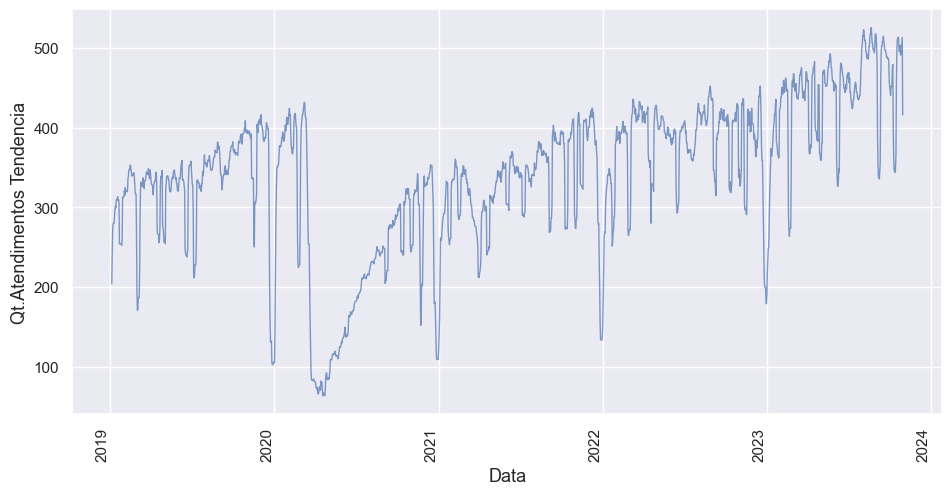

In [47]:
plota_serie_temporal(trend.index, trend,'Tendencia')

A série temporal tem uma tendência positiva predominante, associada a variações regulares e padrões recorrentes.

Observamos um padrão regular de valores altos e baixos em relação ao Eixo y, isso geralmente indica a presença de sazonalidade em nossa série temporal, com **exceção do período de COVID** como mencionado anteriormente. A sazonalidade se refere a padrões regulares ou ciclos que se repetem em intervalos fixos diariamente para o tipo de atendimento "Consulta"

**5.1.1.2 Plot da Sazonalidade:**

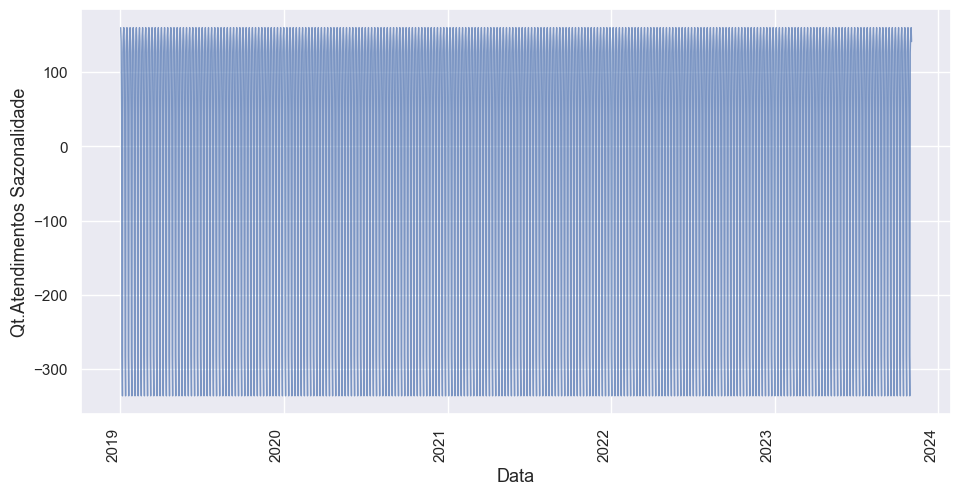

In [48]:
plota_serie_temporal(seasonal.index, seasonal, 'Sazonalidade')

Vamos olhar o padrão da Sazonalidade em uma janela de tempo menor, a fim de enxergar melhor esse comportamento. Percebemos que **cada mês** possui aproximadamente **4 picos e 4 baixas**, sinalizando que os **ciclos sazonais** se repetem em intervalos fixos **semanais**.

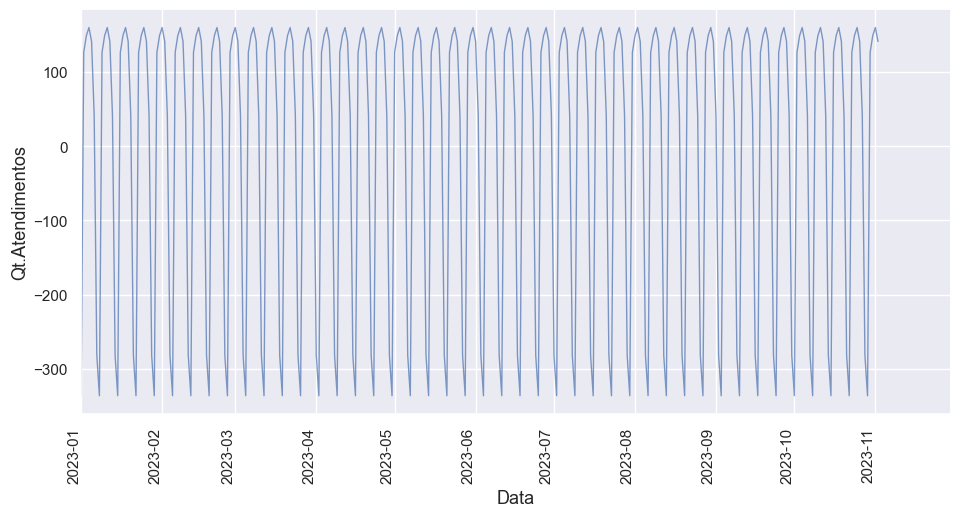

In [49]:
#Visualizando com Zoom a Sazonalidade no ano de 2023
dataInicial = data(1, 1, 2023)
dataFinal = data(30, 11, 2023)
plota_zoom_serie_temporal(seasonal.index, seasonal, dataInicial, dataFinal)

**5.1.1.3 Plot do Resíduo:**

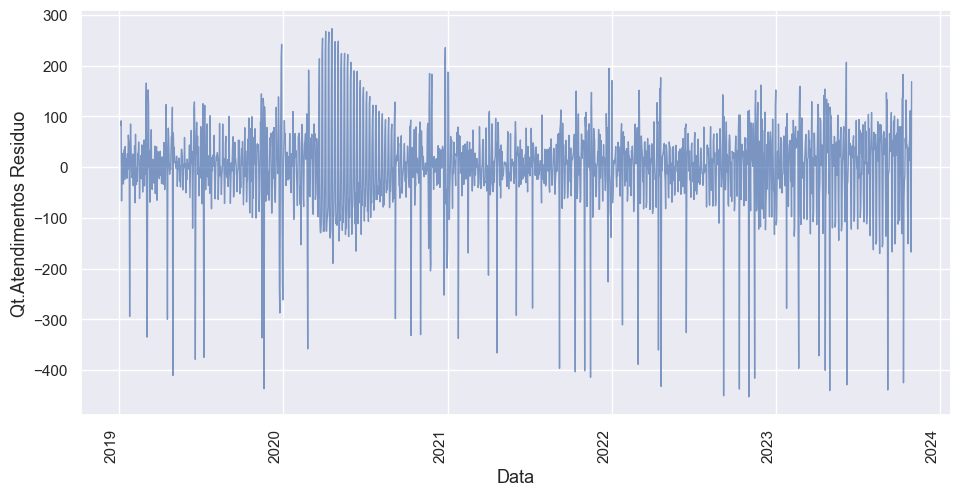

In [50]:
plota_serie_temporal(residual.index, residual,'Residuo')

Uma parte ruído aparenta ter padrões aleatórios. Os valores negativos são relativamente altos, podendo indicar variações significativas abaixo da tendência e da sazonalidade. 
Capturar bem os padrões na série temporal e a previsão dos valores pode ser um desafio.

Vamos observar a distribuição de Ruído:

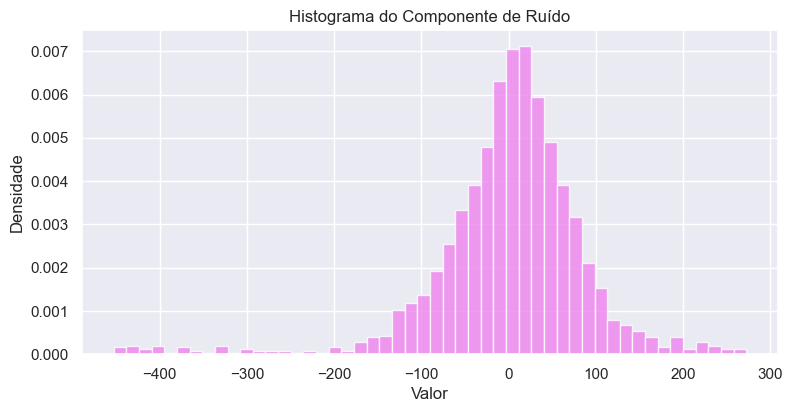

In [51]:
def analyze_residual(residual):
    # Histograma do componente de ruído
    plt.figure(figsize=(8, 4))
    plt.hist(residual, bins=50, density=True, alpha=0.8, color='violet')
    plt.title("Histograma do Componente de Ruído")
    plt.xlabel("Valor")
    plt.ylabel("Densidade")
    plt.show()

analyze_residual(residual)

A faixa de valores entre -200 e 200 apresenta uma distribuição Gaussiana, equanto que as faixas inferior e superior aparentam outliers.

Isso é consistente com a ideia de que a série temporal pode ter valores aleatórios e períodos com variações anômalas. Ao modelar a série temporal, poderíamos tratar os outliers e nos concentrar na modelagem das partes centrais que parecem seguir uma distribuição normal ou mantê-los e avaliar o resultado.

Mas, até aqui os dados mostram que a escolha de um modelo ARIMA (AutoRegressive Integrated Moving Average) _pode_ ser uma alternativa válida.

Vimos os plots de vários gráficos e a análise visual é importante. Da mesma forma, alguns **Testes Estatísticos** podem nos dar informações que reforçam o entendimento dos dados.

#### 5.1.2 Detecção de Anomalias
É importante realizar a detecção de anomalias. Nossa avaliação se baseia em uma abordagem cujos pontos do passado irão gerar a previsão do próximo ponto adicionando uma variável aleatória - geralmente o ruído branco. Iremos considerar, para efeito de análise, os dados a partir de 2022:

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

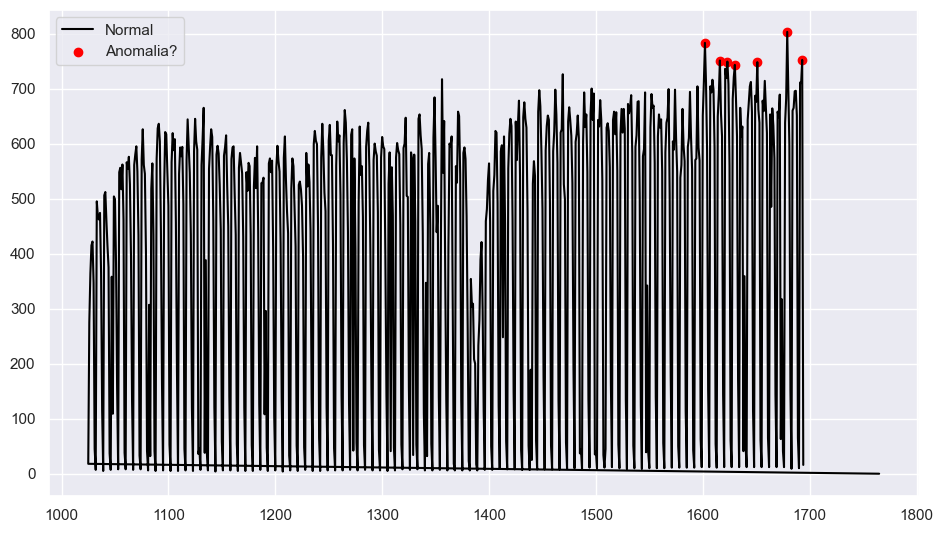

In [53]:
#Copiando o dataset original para as devidas modificações
ds_anomalia = ds_tot_consulta.copy()
op.converte_para_datetime(ds_anomalia, ['Dia_Atendimento'], format=DATE_FORMAT)
ds_anomalia = ds_anomalia[ds_anomalia['Dia_Atendimento'] >= datetime(2022,1,1)]
# Standardizando os dados
scaler = StandardScaler()
#Dados normalizados (como Numpy)
np_scaled = scaler.fit_transform(ds_anomalia['Total_atendimentos'].values.reshape(-1, 1))
#Convertendo para dataframe
data = pd.DataFrame(np_scaled)

# train isolation forest (algoritmo projetado para detectar anomalias - anomalias são mais fáceis de "isolar" do que pontos de dados normais)
model =  IsolationForest(contamination=0.01)
model.fit(data)

ds_anomalia['anomalia'] = model.predict(data)
# visualization
fig, ax = plt.subplots(figsize=(10,6))
#Valores mais próximos de -1 indicam uma maior probabilidade de ser uma anomalia.
ds_isolamento = ds_anomalia.loc[ds_anomalia['anomalia'] == -1, ['Total_atendimentos']] #anomaly

ax.plot(ds_anomalia.index, ds_anomalia['Total_atendimentos'], color='black', label = 'Normal')
ax.scatter(ds_isolamento.index,ds_isolamento['Total_atendimentos'], color='red', label = 'Anomalia?')
plt.legend()
plt.show();

O dados previstos como "anomalias" correspondem a um aumento efetivo de Atendimentos no fim de 2023, sendo inclusive uma projeção da tendência vista na mesma época do ano anterior e assim é considerada uma recuperação do período pós-pandemia. Não identificamos valores que mereçam tratamento nesse sentido.

Os dados originais não seguem uma distribuição normal, com __p-values__ muito baixos (assimetria significativa e curtose diferente de três).

### 5.1.3 - Estacionariedade

**Séries Estácionárias** X **Não Estacionárias**

Basicamente, é como uma série se ao longo do tempo em relação à propriedades estatísticas (tipo  média, variância e autocorrelação) de foma que não mudem significativamente com o passar do tempo - Isso simplifica as análises e permite fazer previsões mais precisas.

Imagem **Exemplificando**:

<img src= "../imagens/estacionaria.PNG" width="70%" align="left">

Teste usando **método estatístico**:

O teste de Dickey-Fuller (ADF) e o teste de Phillips-Perron (PP) são comumente usados para verificar formalmente a estacionariedade.

In [54]:
def avalia_estacionariedade(teste):
    pvalue = teste[1]
    if pvalue < 0.05:
        print('A série é Estacionária')
    else:
        print('A série é Não Estacionária')

teste_fuller = adfuller(ds_tot_consulta['Total_atendimentos'])

avalia_estacionariedade(teste_fuller)

A série é Estacionária


A Série **é estacionária**, portanto não faremos transformações nos dados quanto a isso também

### 5.1.4 Autocorrelação

Auto correlação entre a Série Temporal e seus LAGs (atraso ou deslocamento) 

<img src= "../imagens/serie_lags.PNG" width="55%" align="left">

A Série Temporal, como já mencionado antes, é uma "coleção" de valores em períodos regulares de tempo. Essa regularidade em que queremos avaliar a previsibilidade de valores pode ser trimestral, mensal, diária, horária, etc. 

Uma das técnicas de modelagem irá fazer uma cópia dos dados "atrasando" as datas para cada valor, a fim de entender a dependência temporal na série - ou seja, a tendência dos valores da série temporal de se correlacionar com cópias anteriores dela mesma. Veremos isso como funções de autocorrelação (ACF) e autocorrelação parcial (PACF). Chamamos esse "atraso" de **LAG**. Por exemplo: se no dia 05/10 temos o valor 130 e no dia 06/10 temos o valor de 85, com o Lag (atraso) de 1 dia, teremos um novo conjunto de dados com 130 no dia 04/10 e 85 no dia 05/10. Em seguida, avaliamos as correlações entre as duas séries.

#### 5.1.4.1 Gráficos ACF e PACF

Nosso objetivo é determinar qual o número de Lags que apresenta uma correlação relevante. 

Os próximos gráficos vão mostrar a ACF e a PACF considerando o intervalo de 1 a 12 dias de atraso.

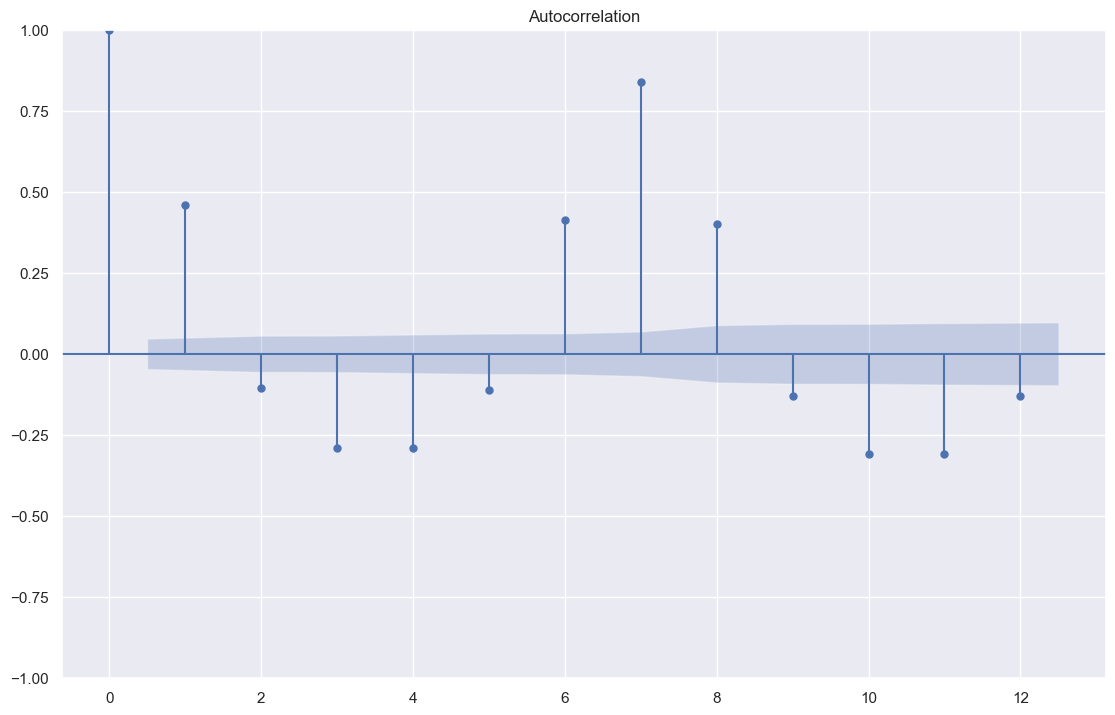

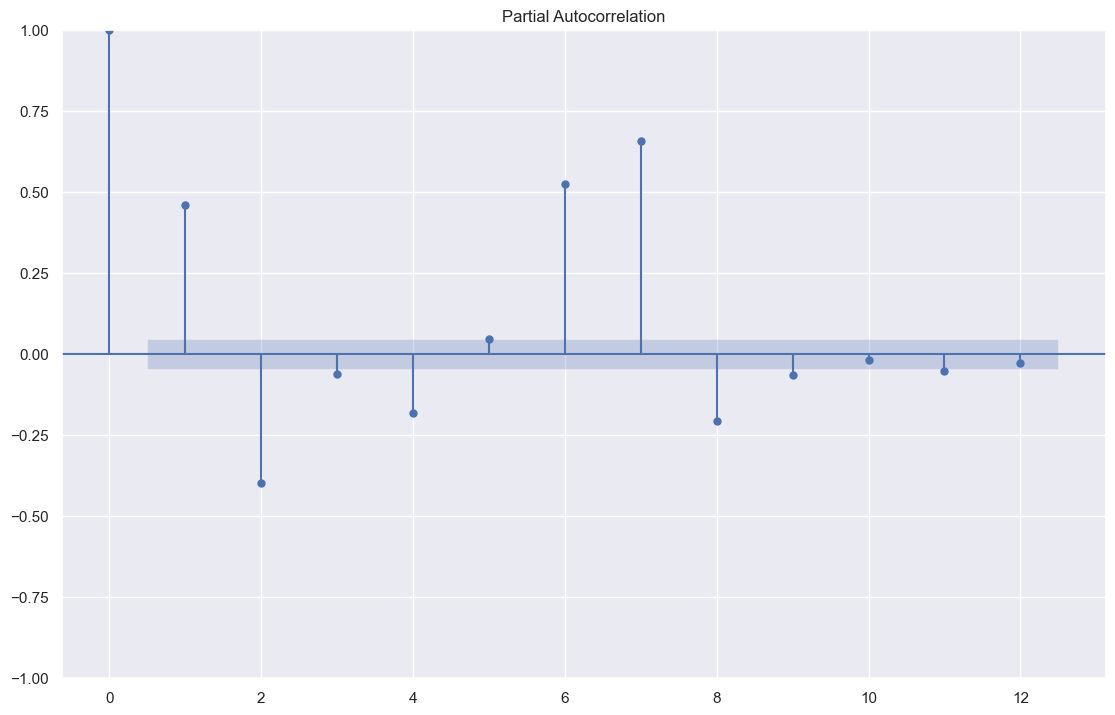

In [55]:
plot_acf(ds_tot_consulta['Total_atendimentos'], lags=12)
plot_pacf(ds_tot_consulta['Total_atendimentos'], lags=12)
plt.show()

**ACF (Função de Autocorrelação):**
Mede a correlação entre uma observações em um determinado ponto no tempo e observações em pontos anteriores. Ela considera ainda o efeito que os valores carregam com o tempo, além de um efeito direto. Um pico significativo no ACF em um determinado lag indica uma correlação significativa entre a observação atual e os valores passados até esse lag.

O ACF é útil para **identificar a ordem dos termos** de média móvel (MA) em modelos **ARIMA**, pois a presença de picos no ACF sugere que há dependência serial significativa até o lag correspondente.

**PACF (Função de Autocorrelação Parcial):** Mede a correlação entre uma observação em um determinado ponto no tempo e observações em pontos anteriores, controlando a correlação das observações intermediárias.

Um pico significativo no PACF em um determinado lag (tendendo a 1.0 ou -1.0) indica uma correlação significativa entre a observação atual e os valores passados até esse lag, excluindo a influência dos lags intermediários.
O PACF é particularmente útil para identificar a ordem dos termos autorregressivos (AR) em modelos ARIMA, pois ele isola a correlação direta entre a observação atual e os lags passados.

Observamos correlações significativas até o **Lag 7** tanto no PACF quanto no ACF. Isso pode sugerir que existe dependência serial significativa. Vamos começar identificando os termos AR com base no PACF e, em seguida, verificar se há correlações significativas remanescentes no ACF que não são explicadas pelos termos AR identificados. Isso pode ajudar na escolha dos termos MA apropriados.

O próximo gráfico de autocorrelação irá exibir um período curto para facilitar a visualização.

Quanto maior for a correlação entre os Lags da série, mais distante o gráfico estará da linha zero. As duas linhas horizontais pontilhadas no gráfico são os níveis de confiança de 95%. Olhando com atenção, é evidente o padrão repetitivo do ciclo semanal e a correlação maior em torno do Lag 7.

#### 5.2.1 Modelo Preditivo #1 - ARIMA / SARIMAX

A partir da análise feita dos componentes da Série, selecionamos o ARIMA (AutoRegressive Integrated Moving Average) que costuma ser eficiente em previsões desse tipo. Outra possibilidade é o SARIMA (Sazonal-ARIMA), pois inclui a contribuição da sazonalidade para a previsão.

**OBS.:** os valores do parâmetro _order_ serão explicados mais a frente 

In [56]:
#Criando um modelo ARIMA com valores iniciais de ordem a partir das análises anteriores
mod = ARIMA(list(ds_tot_consulta['Total_atendimentos']), order=(7,0,11))
res = mod.fit()
pred = res.predict()

In [57]:
#Criando um modelo SARIMAX com valores iniciais de ordem a partir das análises anteriores
mod_sarimax = SARIMAX(list(ds_tot_consulta['Total_atendimentos']), order=(7,0,11))
res_sarimax = mod_sarimax.fit()
pred_sarimax = res_sarimax.predict()

In [58]:
#Transforma a previsão em uma plotagem gráfica sobrepondo Real x , imprimindo também o R-quadrado
def previsao_modelo(predicao):
    print("Score R2", r2_score(ds_tot_consulta['Total_atendimentos'], predicao))

    # Criando a figura e eixos separados
    fig2, ax2 = plt.subplots(figsize=(10, 6))

    # Plotando os dados reais e as previsões
    ax2.plot(list(ds_tot_consulta['Total_atendimentos']), label='Actual Total Atendimentos')
    ax2.plot(predicao, label='Predicted Total Atendimentos')

    # Adicionando rótulos, legenda e título
    ax2.set_xlabel('Timesteps')
    ax2.set_ylabel('Total Atendimentos')
    ax2.legend()

    # Exibindo o gráfico
    plt.show()

Plot do ARIMA

Score R2 0.8386984816363544


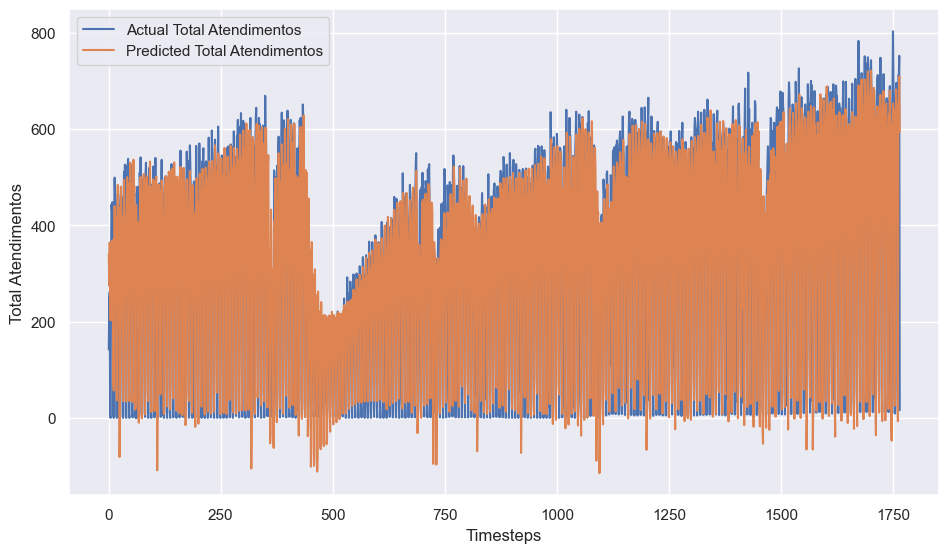

In [59]:
previsao_modelo(pred)

Plot do SARIMAX

Score R2 0.8381714381682868


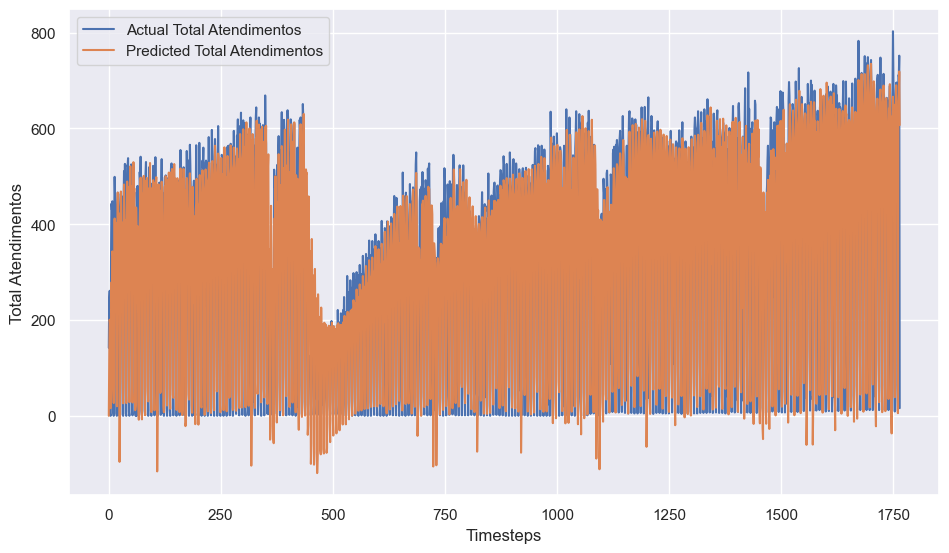

In [60]:
previsao_modelo(pred_sarimax)

Ambos tiveram um desempenho muito parecido.

Tivemos um bom **R-Quadrado**: 0.838 (medida estatística da variação da variável resposta que é explicada por um modelo linear, ou, quão próximos os dados estão da linha de regressão ajustada). 

Mas o que significam os parâmetros de ordem escolhidos?

**Parâmetros da Ordem do Modelo**:

p: Ordem da parte auto-regressiva (AR) do modelo - número de lags da variável dependente que serão usados como preditores.

d: Ordem da diferenciação - quantas vezes a série temporal precisa ser diferenciada para torná-la estacionária.

q: Ordem da média móvel (MA) do modelo - número de lags dos erros que serão usados como preditores.

#### Grid Search
Vamos usar a técnica de **Grid Search** para explorar combinações dos parâmetros p e q para a Ordem do modelo. Vamos checar o modelo ARIMA com "p" e "q" variando de 7 a 11.

In [62]:
# Grid search com cross-validation para optimal P e Q
data_array = ds_tot_consulta[['Total_atendimentos']].values
avg_errors = []
for p in range(7, 12):
    for q in range(7, 12):
        errors = []
        tscv = TimeSeriesSplit(test_size=5)
        for train_index, test_index in tscv.split(data_array):
            X_train, X_test = data_array[train_index], data_array[test_index]
            X_test_orig = X_test

            fcst = []
            for step in range(5):
                try:
                    mod = ARIMA(X_train, order=(p,0,q))
                    res = mod.fit()
                    fcst.append(res.forecast(steps=1))
                except:
                    print('errorred')
                    fcst.append(-9999999.)
                X_train = np.concatenate((X_train, X_test[0:1,:]))
                X_test = X_test[1:]
            errors.append(r2_score(X_test_orig, fcst))
        pq_result = [p, q, np.mean(errors)]
        print("proces->", p,",", q)
        avg_errors.append(pq_result)

avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ['p', 'q', 'error']
result = avg_errors.pivot(index='p', columns='q')

proces-> 7 , 7
proces-> 7 , 8
proces-> 7 , 9
proces-> 7 , 10
proces-> 7 , 11
proces-> 8 , 7
proces-> 8 , 8
proces-> 8 , 9
proces-> 8 , 10
proces-> 8 , 11
proces-> 9 , 7
proces-> 9 , 8
proces-> 9 , 9
proces-> 9 , 10
proces-> 9 , 11
proces-> 10 , 7
proces-> 10 , 8
proces-> 10 , 9
proces-> 10 , 10
proces-> 10 , 11
proces-> 11 , 7
proces-> 11 , 8
proces-> 11 , 9
proces-> 11 , 10
proces-> 11 , 11


In [63]:
print("Melhores valores:", result)

Melhores valores:        error                                        
q         7         8         9         10        11
p                                                   
7   0.589083  0.503110  0.626972  0.616687  0.632610
8   0.622372  0.467988  0.592019  0.531770  0.554323
9   0.591277  0.603118  0.610424  0.605494  0.617830
10  0.619984  0.606482  0.622311  0.568272  0.631983
11  0.632858  0.620614  0.620461  0.597240  0.633525


**Com base no resultado**, a melhor escolha **seria p = 8 e q = 8** (o menor erro positivo, ou 0,468439). Entretanto, conforme as análises do ACF e PACF já indicavam, os valores **p = 7 e q = 7** também são candidatos fortes.

De fato, ao testar ambos os valores de parâmetros (7 e 8), tivemos **melhor performance** com o **valor 7** e por isso, mantivemos este último.

**Obs.:** Após executar este código, à medida que aumentamos "p" e "q" percebemos o impacto: o tempo de treinamento sobe exponencialmente. Portanto, é aconselhável analisar e reduzir a faixa de valores previamente para então experimentar.

Vale dizer que o valor dos melhores parâmetros também podem depender da métrica de avaliação.



Agora, vamos verificar a previsão para os **14 dias seguintes**:

In [61]:
#1 - Treinando o Modelo com os parâmetros definidos
serie_consultas = ds_tot_consulta['Total_atendimentos']
serie_consultas.index=ds_tot_consulta['Dia_Atendimento']

X_treino = serie_consultas.loc[serie_consultas.index <= '2023-10-19']
X_teste  = serie_consultas.loc[serie_consultas.index > '2023-10-19']

mod_arima = ARIMA(X_treino, order=(7,0,7))
arima_fit = mod_arima.fit()
pred = res.predict()

In [62]:
predicao = arima_fit.forecast(steps=14)

In [63]:
print("RMSE", np.sqrt(mean_squared_error(X_teste, predicao)))
print("Score R2", r2_score(X_teste, predicao))

RMSE 164.5576946079556
Score R2 0.7115295336909697


O R-Quadrado aumentou e a Raiz do Erro Quadrático Médio (RMSE) não parece muito boa: em média, o modelo está **cometendo um erro** de 164 dias na previsão.

In [64]:
predic = pd.Series(predicao)
predic.index = X_teste.index

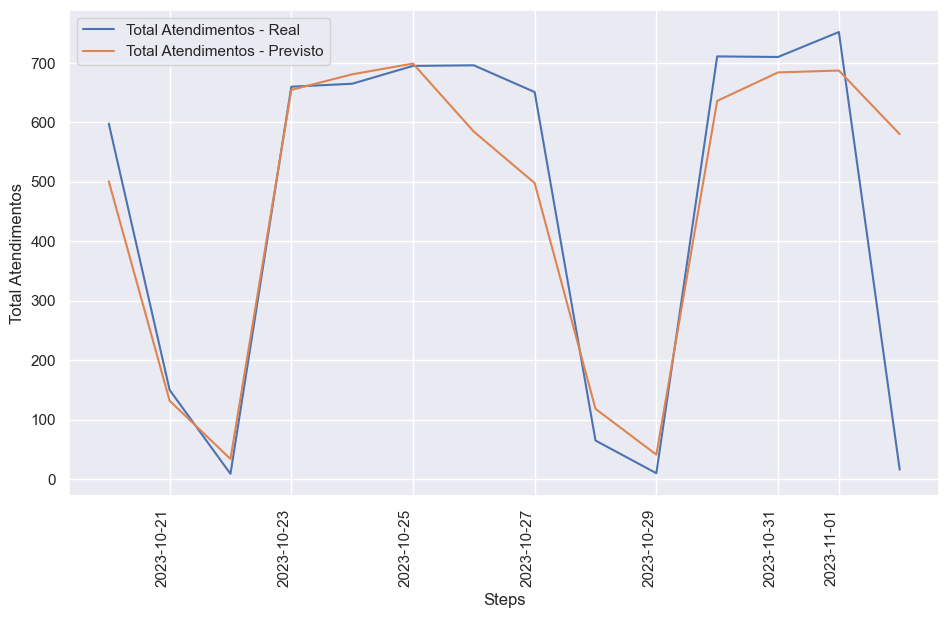

In [65]:
plots_simultaneos(X_teste, predic)

Da forma que está, notamos uma **boa aproximação dos valores reais**. Mas, o **R-quadrado aumentou** nos dados de **teste**

Existem diversas bibliotecas que facilitam e automatizam análises ou tomam decisões sobre escolhas da modelagem. A **biblioteca Prophet** desenvolvida pelo Facebook se tornou bastante popular nessa categoria de Séries Temporais.

Vamos checar sua performance utilizando-a da forma mais simples e direta possível. Vamos ver se seu desempenho é melhor.

#### 5.2.2 Modelo Preditivo #2 - Prophet

O Prophet requer um dataframe com duas colunas: **ds** (coluna temporal) e **y** (coluna de valores)

In [66]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [67]:
ds_serie_consultas = X_treino.copy()
ds_serie_consultas = pd.DataFrame(data={'ds':ds_serie_consultas.index, 'y': ds_serie_consultas})

In [68]:
ds_serie_consultas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1752 entries, 2019-01-02 to 2023-10-19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1752 non-null   datetime64[ns]
 1   y       1752 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 41.1 KB


In [69]:
# Configurando o modelo: intervalo de incerteza configurado para 90% (o padrão do Prophet é 80%)
modelo_pro = Prophet()
modelo_pro.add_country_holidays(country_name="BR")
modelo_pro.fit(ds_serie_consultas)

21:29:30 - cmdstanpy - INFO - Chain [1] start processing
21:29:30 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
dias_futuros = modelo_pro.make_future_dataframe(periods=14)

In [71]:
predicaoProph = modelo_pro.predict(dias_futuros)

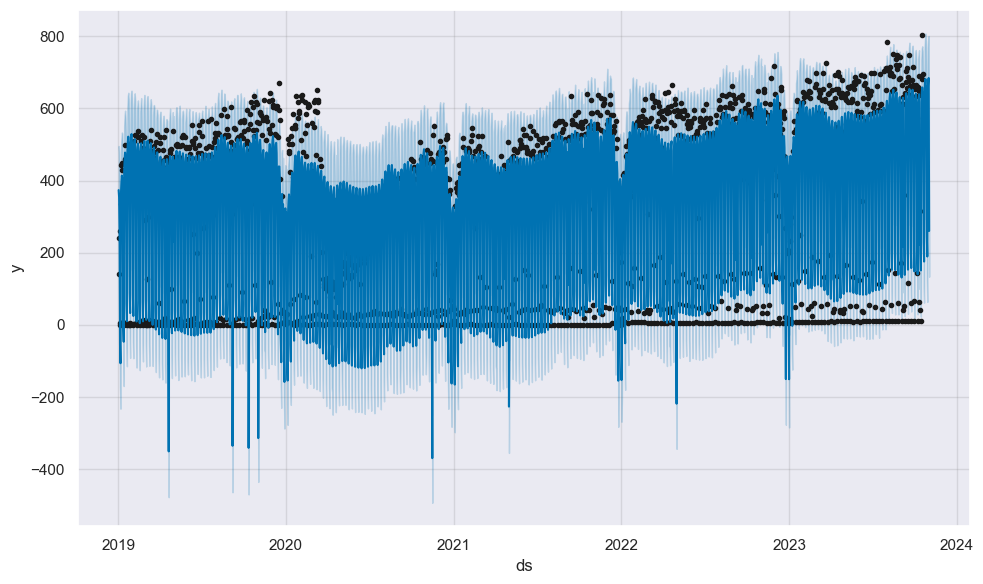

In [72]:
modelo_pro.plot(predicaoProph, uncertainty=True);

Os pontos são os valores reais e as linhas azui, os previstos. O Prophet está encontrando dificuldade na aproximação com os valores reais.

In [73]:
mse = mean_squared_error(X_teste, predicaoProph['yhat'][-14:])
print('RMSE: %.3f' % (np.sqrt(mse)))
print("Score R2", r2_score(X_teste, predicaoProph['yhat'][-14:]))

RMSE: 112.838
Score R2 0.8643638102216995


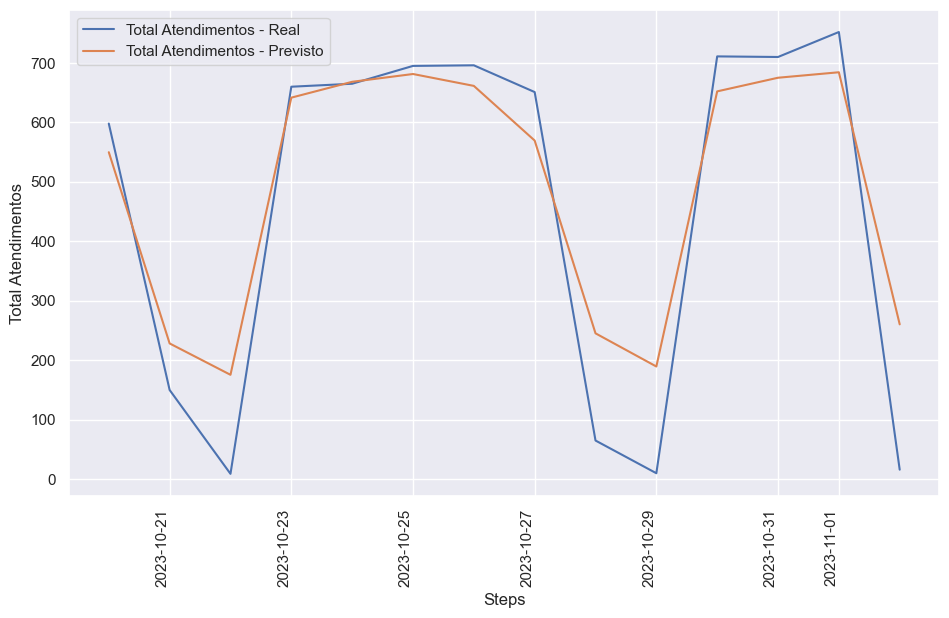

In [74]:
figs, axs = plt.subplots(figsize=(10, 6))
axs.plot(X_teste.index, X_teste, label='Total Atendimentos - Real')
axs.plot(predicaoProph['ds'][-14:], predicaoProph['yhat'][-14:], label='Total Atendimentos - Previsto')
axs.set_xlabel('Steps')
axs.set_ylabel('Total Atendimentos')    
axs.legend()
plt.xticks(rotation=90, ha='right')
plt.show()

O **Prophet** se saiu melhor com a métrica de desempenho (**RMSE de 112.838, contra 164.43 do ARIMA**). Além disso, foi melhor para prever os picos.

Tentaremos mais uma abordagem:

#### 5.2.3 Modelo Preditivo #3 - Recurrent Neural Network

Criaremos uma **Rede Neural Recorrente (RNN)** com uma camada **LSTM** (Long Short-Term Memory): muito boas para capturar dependências de longo prazo em séries temporais.

Uma RNN tem a capacidade de "lembrar do passado", uma vez que, diferente dos modelos convencionais em que usamos atributos X para prever um valor y, em séries temporais, usamos o passado sequencial de X para prever seu futuro. A camada LSTM resolve algumas limitações da arquitetura RNN - entre elas, a dificuldade de processar sequências longas.

In [33]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.losses import Huber
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.models import load_model
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler


##### 5.2.3.1 Preparação:

A fim de permitir a execução apenas desta etapa de Rede Neural (sem as células anteriores), será refeito o código de leitura e preparação dos dados, como consolidação dos totais, conversão para o tipo data, etc.

Assim, a Próxima célula **é executada para entrada na previsão exclusivamente da Rede Neural**. Os imports no começo do Notebook também são necesários, além dos métodos agrupa_totais_por(), filtra_dados_por_tipo() e plots_simultaneos().

In [10]:
#Lê  planilha com a base de atendimentos
ds_atendimentos = op.le_planilha( dataset_path + file, separador=";")
#Converte o campo em data
op.converte_para_datetime(ds_atendimentos, ['Data'], format=DATETIME_FORMAT)
#Agrupa o total de atendimentos por tipo
ds_tot_atendimento = agrupa_totais_por(ds_atendimentos, ['Tipo_atendimento', 'Dia_Atendimento'])
op.converte_para_datetime(ds_tot_atendimento, ['Dia_Atendimento'], format=DATE_FORMAT)
#Ordena por data
ds_tot_atend_dia = ds_tot_atendimento.sort_values(by="Dia_Atendimento")
#Obtém as consultas (desconsiderando internações, exames e urgências)
ds_tot_consulta = filtra_dados_por_tipo(ds_tot_atendimento, CONSULTA)
ds_tot_consulta = ds_tot_consulta[['Dia_Atendimento', 'Total_atendimentos']]
op.converte_para_datetime(ds_tot_consulta,['Dia_Atendimento'])
# Período de datas existentes: 
data_inicio = ds_tot_consulta['Dia_Atendimento'].min()
data_fim = ds_tot_consulta['Dia_Atendimento'].max()
intervalo_datas = pd.date_range(start=data_inicio, end=data_fim)
# Criando um conjunto de datas a partir do DataFrame original
datas_no_dataset = set(ds_tot_consulta['Dia_Atendimento'])
# Dataframe com "gaps" de datas (ausentes)
datas_faltantes = [data for data in intervalo_datas if data not in datas_no_dataset]
df_datas_faltantes = pd.DataFrame({'Dia_Atendimento': datas_faltantes, 'Total_atendimentos': [0] * len(datas_faltantes)})
# Juntando os dataframes
ds_tot_consulta = pd.concat([ds_tot_consulta, df_datas_faltantes], ignore_index=True)
# Ordenando o DataFrame pelo campo 'Dia_Atendimento' se necessário
ds_tot_consulta = ds_tot_consulta.sort_values(by='Dia_Atendimento')

In [12]:
#transforma dados unidimensionais em um formato adequado para treinar modelos de Redes Neurais Recorrentes (RNNs) e LSTMs,
#criando pares de entrada (X) e saída (y) para o modelo aprender a prever o valor de uma variável com base em uma janela 
#deslizante de valores anteriores (sequências de "window_size" dias anteriores de entrada (X) e o próximo dia como o rótulo (y)).
def redimension(ds, window_size=7):
    ds_numpy = ds.to_numpy()
    X = []
    y = []
    for i in range(len(ds_numpy) - window_size):
        row = [[a] for a in ds_numpy[i : i+window_size]]
        X.append(row)
        label = ds_numpy[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [11]:
ds_tot_consulta.index = ds_tot_consulta['Dia_Atendimento']
ds_temp = ds_tot_consulta['Total_atendimentos']

In [13]:
scaler = MinMaxScaler()
ds_temp2 = scaler.fit_transform(np.array(ds_temp).reshape(-1, 1))
ds_temp2

array([[0.17683686],
       [0.30136986],
       [0.32503113],
       ...,
       [0.88418431],
       [0.93648817],
       [0.01992528]])

In [14]:
WINDOW_SIZE = 8
X, y = redimension(ds_temp, WINDOW_SIZE)

In [15]:
#Métrica que reremos usar para pré-avaliar a performance do modelo
def metrica_performance(val_real, val_previsto):
    mse = np.sqrt(mean_squared_error(val_real, val_previsto))
    print("RMSE:", np.sqrt(mse))

In [32]:
#passos para dividir os dados no conjunto de treino, validação e teste, dadas as quantidades para essa divisão
#Normalmente, usamos a base de Validação para ajustar os hiperparâmetros (como taxa de aprendizado, número de camadas, etc.) e evitar overfitting.
def split_train_val_test(X, y, qt_train, qt_test):
    X_train, y_train = X[:qt_train], y[:qt_train]
    X_val, y_val = X[qt_train: qt_test], y[qt_train: qt_test]
    X_test, y_test = X[qt_test:], y[qt_test:]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
#Passos para fazer a predição do modelo e já exibir a métrica de performance
def predicao_rnn(X, y, modelo):
    predicao = modelo.predict(X).flatten()
    ds_result = pd.DataFrame({"Pred":predicao, "Valor real":y})
    metrica_performance(y, predicao)
    return ds_result

In [18]:
#Determinação das quantidades de amostras de treino e teste
TEST = 1600
TRAIN = 1300

In [19]:
X_treino, y_treino, X_val, y_val, X_teste, y_teste = split_train_val_test(X, y, TRAIN, TEST)

In [20]:
#Revendo a quantidade final de amostras da divisão de treino, validação e teste
X_treino.shape, y_treino.shape, X_val.shape, y_val.shape, X_teste.shape, y_teste.shape

((1300, 8, 1), (1300,), (300, 8, 1), (300,), (158, 8, 1), (158,))

In [36]:
#Queremos fazer uso do ModelCheckpoint: usado em conjunto com o treinamento usando model.fit() para salvar um modelo 
#(num arquivo de ponto de verificação) em intervalos, para que o modelo possa ser carregados posteriormente para continuar 
# o treinamento a partir do estado salvo.
checkpoint = ModelCheckpoint('modelo_nn/checkpoint.model.keras', save_best_only=True)

**Informações sobre a Arquitetura da RNN**

Criamos um método para facilitar a experimentação inicial.

Adicionamos duas camadas LSTM empilhadas para que a Rede capture padrões mais complexos e hierárquicos.

Normalmente, incluímos uma Regularização Dropout para prevenir overfitting, especialmente em conjuntos de dados ruidosos ou reduzidos. Nossa tentativa neste caso, talvez devido à pequena quantidade de amostras, foi um pouco demais já que ela "desliga" neurônios durante o treinamento, reduzindo a capacidade da rede aprender padrões complexos. Quando os dados são limitados, estratégias diferentes de regularização e otimização podem ser mais eficazes, como a L2.

Experimentamos diferentes tamanhos de janela (WINDOW_SIZE) para capturar tendências sazonais ou semanais. Valores maiores, como WINDOW_SIZE=14 ou WINDOW_SIZE=30, poderiam capturar outros padrões sazonais.

Os demais hiperparâmetros nos dão flexibilidade para testar modelagens diferentes do algoritmo

In [57]:
def setup_and_compile_rnn(optim=Adam, activ='linear', lr=0.0001, lozz=MeanSquaredError(), metrics='mae'):
    modelo = Sequential()
    modelo.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))
    modelo.add(LSTM(128, return_sequences=True))
    #.add(Dropout(0.2))
    modelo.add(LSTM(64))
    #modelo.add(Dropout(0.05))
    modelo.add(Dense(WINDOW_SIZE, activation=activ))
    modelo.add(Dense(1, 'linear'))
    modelo.compile(loss=lozz, metrics=[metrics],optimizer=RMSprop(learning_rate=lr) )
    return modelo

In [58]:
#O mesmo método anterior, com regularização L2 (que penaliza pesos grandes, ajudando a evitar overfitting sem reduzir a capacidade da rede)
def setup_compile_rnn_regularizacao(optim=Adam, activ='linear', lr=0.0001, lozz=MeanSquaredError(), metrics='mae'):
    modelo = Sequential()
    modelo.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))
    modelo.add(LSTM(128, kernel_regularizer=l2(0.001), return_sequences=True))
    modelo.add(LSTM(64, kernel_regularizer=l2(0.001)))
    modelo.add(Dense(WINDOW_SIZE, activation=activ))
    modelo.add(Dense(1, 'linear'))
    modelo.compile(loss=lozz, metrics=[metrics],optimizer=RMSprop(learning_rate=lr) )
    return modelo


##### 5.2.3.2 Montando as Redes, executando o Treinamento e Verificando a Performance

In [ ]:
modelo_nn1 = setup_and_compile_rnn(optim=Adam, activ='linear', lr=0.0001, lozz=MeanSquaredError())
modelo_nn1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 8, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,497 (455.07 KB)

 Trainable params: 116,497 (455.07 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
#Treinando o modelo e configurando o callback para salvar o melhor
epoc = 300
modelo_nn1.fit(X_treino, y_treino, validation_data=(X_val, y_val), epochs=epoc, callbacks=[checkpoint])

Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 54585.9336 - mae: 211.7750 - val_loss: 86522.1953 - val_mae: 288.3660
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53948.9297 - mae: 211.1019 - val_loss: 86515.0000 - val_mae: 288.3534
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53180.0469 - mae: 209.1072 - val_loss: 86497.8203 - val_mae: 288.3231
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52714.7148 - mae: 207.9247 - val_loss: 86526.4688 - val_mae: 288.3735
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 55302.2812 - mae: 213.5010 - val_loss: 86526.1406 - val_mae: 288.3730
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54381.1406 - mae: 211.5777 - val_loss: 86520.5000 - val_mae: 288.3630
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53669.4297 - mae: 210.0353 - val_loss: 86509.9844 - val_mae: 288.3445
Epoch 8/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53594.3945 - mae: 210.1230 - val_loss:

In [60]:
ds_result_teste = predicao_rnn(X_teste, y_teste, modelo_nn1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
RMSE: 11.6293229313725


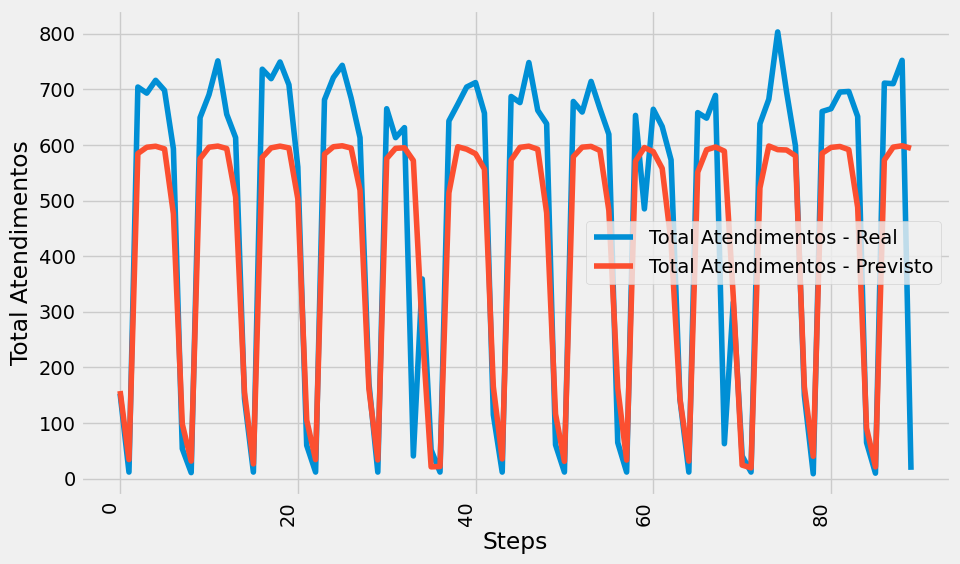

In [61]:
plots_simultaneos(ds_result_teste['Valor real'], ds_result_teste['Pred'])

Saímos do modelo anterior (Prophet) com um RMSE de 112.84 para o atual: 11.62. **Na média** o ganho foi sensivelmente melhor. O gráfico mostra algumas discrepânicias, ainda.

O mesmo exemplo anterior, com regularização L2

Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 163019.9062 - mae: 331.3569 - val_loss: 281301.6250 - val_mae: 460.8403
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 158396.2656 - mae: 321.6975 - val_loss: 278560.2188 - val_mae: 457.8585
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 158596.7344 - mae: 324.9918 - val_loss: 276604.2500 - val_mae: 455.7202
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 153021.8906 - mae: 316.8574 - val_loss: 275054.2188 - val_mae: 454.0170
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 155197.3750 - mae: 317.2479 - val_loss: 273690.3750 - val_mae: 452.5896
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 151360.4844 - mae: 314.9072 - val_loss: 272485.3750 - val_mae: 451.5720
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 151336.2344 - mae: 312.5795 - val_loss: 271360.8750 - val_mae: 450.6554
Epoch 8/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 151816.6562 - mae: 316.

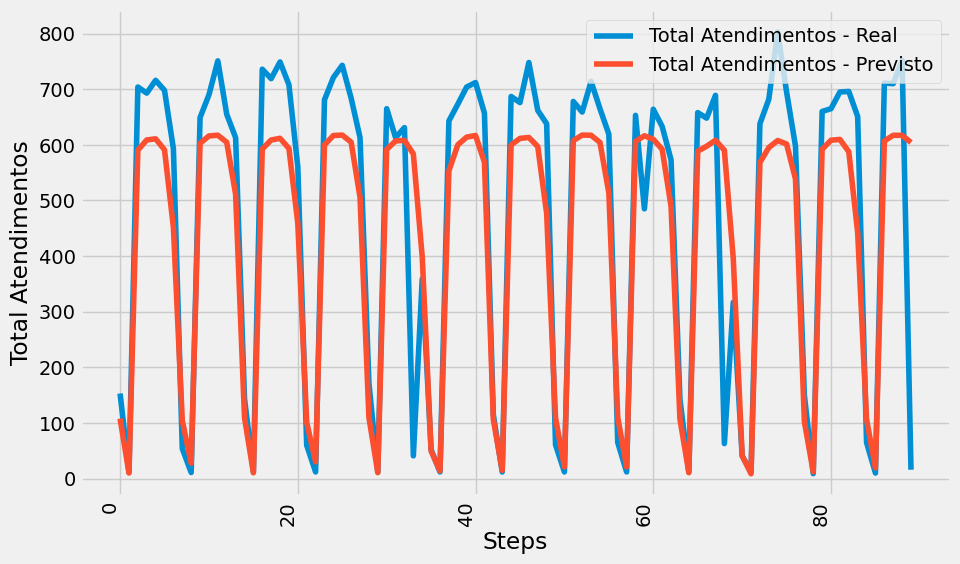

In [48]:
modelo_nn2 = setup_compile_rnn_regularizacao(optim=Adam, activ='linear', lr=0.0001, lozz=MeanSquaredError())
modelo_nn2.fit(X_treino, y_treino, validation_data=(X_val, y_val), epochs=epoc) #Sem o callback
ds_result_teste_L2 = predicao_rnn(X_teste, y_teste, modelo_nn2)
plots_simultaneos(ds_result_teste_L2['Valor real'], ds_result_teste_L2['Pred'])

Um dos objetivos da Regularização é prevenir o overfiting (aprendizado excessivo dos dados de Treino, mas que não performam bem com os de Teste). Porém, parece não está permitindo o aprendizado dos valores mais altos. 

In [63]:
TEST = 1668
TRAIN = 1638
X_treino, y_treino, X_val, y_val, X_teste, y_teste = split_train_val_test(X, y, TRAIN, TEST)

epoc = 300
#Alterando a função de ativação de Linear para Exponential
modelo_nn_exp = setup_and_compile_rnn(optim=Adam, activ='exponential', lr=0.0001, lozz=MeanSquaredError())
modelo_nn_exp.fit(X_treino, y_treino, validation_data=(X_val, y_val), epochs=epoc, batch_size=32)

Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 160470.3906 - mae: 327.8789 - val_loss: 227486.7031 - val_mae: 415.6620
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93935.8828 - mae: 265.2017 - val_loss: 93203.2266 - val_mae: 297.2979
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47365.3477 - mae: 195.6113 - val_loss: 57452.6094 - val_mae: 232.3507
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28872.5059 - mae: 146.4855 - val_loss: 43260.3125 - val_mae: 194.6407
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21887.0449 - mae: 119.1794 - val_loss: 34020.7656 - val_mae: 125.0046
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20545.2930 - mae: 110.3553 - val_loss: 30431.3516 - val_mae: 157.8612
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18757.2559 - mae: 102.8951 - val_loss: 16146.3906 - val_mae: 96.4305
Epoch 8/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17993.4727 - mae: 96.7637 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
RMSE: 11.489651618561886


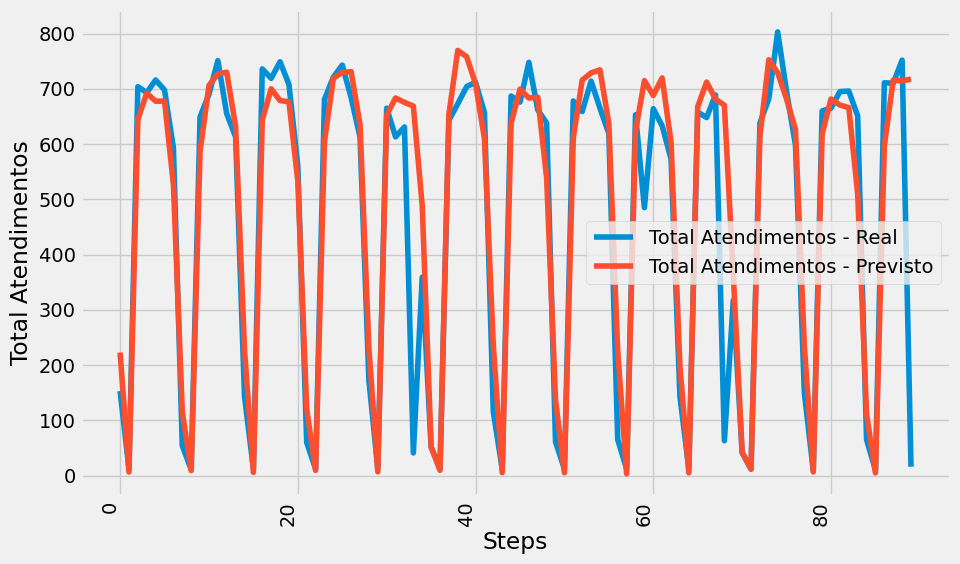

In [64]:
ds_result_teste_exp = predicao_rnn(X_teste, y_teste, modelo_nn_exp)
plots_simultaneos(ds_result_teste_exp['Valor real'], ds_result_teste_exp['Pred'])

O resultado, com o RMSE melhorou um pouco. Mas, a semelhança da previsão no gráfico é ainda melhor.

Normalmente a **função de ativação ‘linear’** é ideal para problemas de regressão, mas o resultado com a ‘exponential’ generalizou melhor.

Testando com **500 epochs**

Epoch 1/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 160221.0156 - mae: 328.1322 - val_loss: 229861.5469 - val_mae: 416.7407
Epoch 2/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 87970.9609 - mae: 253.1110 - val_loss: 70239.9219 - val_mae: 254.9233
Epoch 3/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49911.8984 - mae: 199.0384 - val_loss: 60385.7305 - val_mae: 237.3910
Epoch 4/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36750.9258 - mae: 166.0600 - val_loss: 39818.4648 - val_mae: 188.3862
Epoch 5/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26243.8945 - mae: 133.0578 - val_loss: 29522.1016 - val_mae: 161.7931
Epoch 6/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22061.8320 - mae: 117.5635 - val_loss: 21946.1113 - val_mae: 133.1141
Epoch 7/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19523.5293 - mae: 108.5325 - val_loss: 25638.0098 - val_mae: 148.6143
Epoch 8/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15868.3887 - mae: 97.2286 - val_los

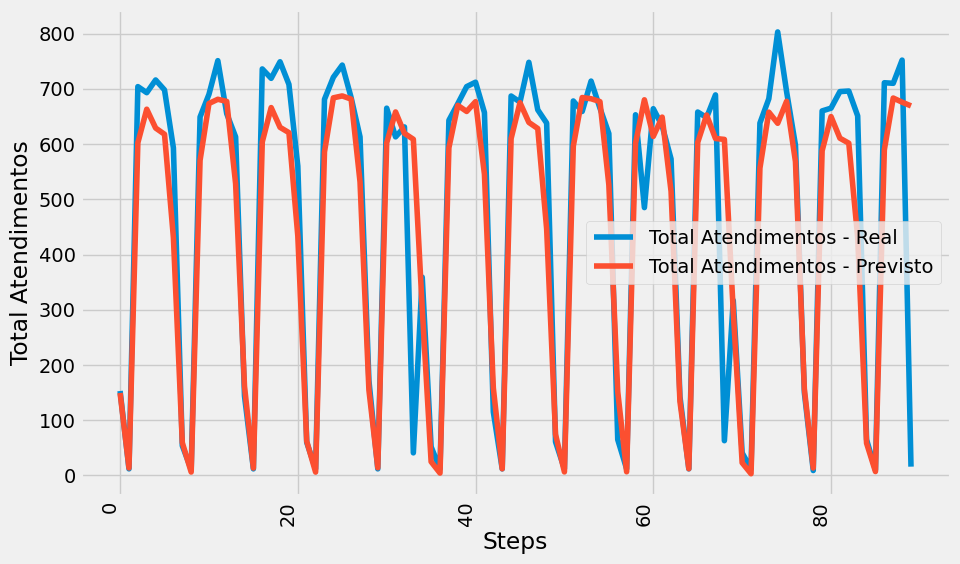

In [66]:
epoc = 500
#Alterando a função de ativação de Linear para Exponential
modelo_nn_exp = setup_and_compile_rnn(optim=Adam, activ='exponential', lr=0.0001, lozz=MeanSquaredError())
modelo_nn_exp.fit(X_treino, y_treino, validation_data=(X_val, y_val), epochs=epoc, batch_size=32, callbacks=[checkpoint])
ds_result_teste_exp = predicao_rnn(X_teste, y_teste, modelo_nn_exp)
plots_simultaneos(ds_result_teste_exp['Valor real'], ds_result_teste_exp['Pred'])


O RMSE com 300 epochs era de 11.49, agora com 500 é de 11.25. Mas, o comportamento gráfico mostra melhoria.


##### 5.2.3.3 Próximas Ações.


É possível testar diversas **variações de arquitetura** de Rede, de **hiperparâmetros**, incluir **mais dados** (atendimentos por hora ou a cada 30 min, por exemplo), utilizar **outros algoritmos de perda, função de ativação, taxa de aprendizagem**, aumentar a **quantidade de camadas, de neurônios, o otimizador, epocas**, enfim, são muitas possibilidades de otimização.

**Mais Abordagens:**

- Reduzir Taxa de Aprendizado por causa do dataset com relativamente poucas amostras(valores como lr=1e-5 ou 1e-6, por exemplo);
- Criars Features Adicionais, como "Dia da semana" (valor categórico ou numérico), Feriados (variável binária "1" para feriados, 0 caso contrário);
Tendências passadas: Inclua médias móveis ou quantidades de consultas nos 7/30 dias anteriores.
- Alterar Função de Perda e Métrica (ex.: Huber Loss, perda ponderada, atribuindo mais peso a dias com maior número de consultas, Quantile Loss, etc);
- Testar outras configurações de Rede como a GRU (Gated Recurrent Unit) que pode superar LSTMs em conjuntos de dados pequenos e menos complexos OU Attention Mechanisms: Modelos de atenção, como o Transformer, podem melhorar o desempenho.

### 6. Salvando o melhor Modelo para testes e Retreinamento

Comumente, o **treinamento** com Redes Neurais é mais **demorado** e vale a pena utilizar o **Modelo salvo pelo ModelCheckpoint** com o recurso de callback. Se assim for, apenas rodamos as rotinas iniciais de carga e transformação dos dados para, em seguida, carregar o modelo e realizar a predição.

Podemos utilizar também esse ponto de entrada:

In [ ]:
model_loaded = load_model('modelo_nn/checkpoint.model.keras')
ds_result_val = predicao_rnn(X_val, y_val, model_loaded)

### 7. Removendo Dataset (mantendo apenas a versão ZIP)

In [ ]:
if os.path.isfile(dataset_path + file):
    os.remove(dataset_path + file)